In [ ]:
# Chantal Ronald 
# Student number: 218035344
# COMP700: Honours Project 
# Project title: Automatic Acoustic Classification of Birds Using Autoencoders

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/xccoverbl_2014.zip 
!unzip gdrive/My\ Drive/kaggle_bird_song_dataset.zip
!unzip gdrive/My\ Drive/nips4b.zip

Streaming output truncated to the last 5000 lines.
  inflating: wavfiles/351049-0.wav   
  inflating: wavfiles/351049-1.wav   
  inflating: wavfiles/351049-10.wav  
  inflating: wavfiles/351049-2.wav   
  inflating: wavfiles/351049-3.wav   
  inflating: wavfiles/351049-4.wav   
  inflating: wavfiles/351049-6.wav   
  inflating: wavfiles/351049-7.wav   
  inflating: wavfiles/351049-8.wav   
  inflating: wavfiles/351049-9.wav   
  inflating: wavfiles/351058-0.wav   
  inflating: wavfiles/351058-1.wav   
  inflating: wavfiles/351058-10.wav  
  inflating: wavfiles/351058-12.wav  
  inflating: wavfiles/351058-13.wav  
  inflating: wavfiles/351058-6.wav   
  inflating: wavfiles/351058-7.wav   
  inflating: wavfiles/351058-9.wav   
  inflating: wavfiles/351065-0.wav   
  inflating: wavfiles/351065-1.wav   
  inflating: wavfiles/351065-10.wav  
  inflating: wavfiles/351065-11.wav  
  inflating: wavfiles/351065-12.wav  
  inflating: wavfiles/351065-2.wav   
  inflating: wavfiles/351065-3.wav   

# **LOAD DATASETS**


## Load Data from *xccoverbl* dataset

In [ ]:
# Prepare training data from metadata file
# https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
import pandas as pd

metadata_file = '/content/xcmeta.csv'
df = pd.read_csv(metadata_file,sep='\t')
df.head()

df['file_path'] = '/content/xccoverbl_2014' + '/xc' + df['id'].astype(str) + '.flac'
df['class'] = df['gen'] + " " + df['sp']
# Use the relevant columns
df = df[['file_path', 'class']]
df.head()


,file_path,class
0,/content/xccoverbl_2014/xc132608.flac,Acanthis flammea
1,/content/xccoverbl_2014/xc132611.flac,Acanthis flammea
2,/content/xccoverbl_2014/xc35068.flac,Acanthis flammea
3,/content/xccoverbl_2014/xc82715.flac,Acrocephalus palustris
4,/content/xccoverbl_2014/xc64685.flac,Acrocephalus palustris


## Load data from *kaggle_bird_song_dataset*

In [ ]:
# kaggle_bird_song_dataset.zip
# audio files stored in wavfiles
# metadata - bird_songs_metadata.csv

metadata_file_1 = '/content/bird_songs_metadata.csv'
df1 = pd.read_csv(metadata_file_1,sep=',')
df1.head()

df1['file_path'] = '/content/wavfiles/' + df1['filename']
df1['class'] = df1['genus'] + " " + df1['species']
# Use the relevant columns
df1 = df1[['file_path', 'class']]
df1.head()


,file_path,class
0,/content/wavfiles/557838-0.wav,Thryomanes bewickii
1,/content/wavfiles/557838-1.wav,Thryomanes bewickii
2,/content/wavfiles/557838-4.wav,Thryomanes bewickii
3,/content/wavfiles/557838-5.wav,Thryomanes bewickii
4,/content/wavfiles/557838-6.wav,Thryomanes bewickii


## Load data from *nips4b* dataset

In [ ]:
metadata_file_2 = '/content/nips4b/nips4b_birdchallenge_train_labels.csv'
df2 = pd.read_csv(metadata_file_2,sep=',', skiprows=[0,1])
df2.head()

df2['Filename'] = '/content/nips4b/train/' + df2['Filename']
df2.drop(df2.columns[[1, 3]], axis=1, inplace=True)
df2.rename(columns={df2.columns[1]:'EMPTY'}, inplace='True')
df2 = df2[:-1]
df2.fillna(0, inplace=True)
df2 = df2.astype('int32', errors='ignore') #make integer labels

"""df2['class'] = df2['genus'] + " " + df2['species']
# Use the relevant columns
df2 = df2[['file_path', 'class']]"""
df2.head()

,Filename,EMPTY,1,2,3,4,5,6,7,8,...,78,79,80,81,82,83,84,85,86,87
0,/content/nips4b/train/nips4b_birds_trainfile00...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/content/nips4b/train/nips4b_birds_trainfile00...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,/content/nips4b/train/nips4b_birds_trainfile00...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/content/nips4b/train/nips4b_birds_trainfile00...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,/content/nips4b/train/nips4b_birds_trainfile00...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# **METHOD DEFINITIONS**

In [ ]:
# load audio file
# extract static and dynamic features
import glob
import librosa
import numpy as np

# https://stackoverflow.com/questions/69727559/want-to-find-the-average-length-of-audio-in-a-bunch-of-audio-files-in-a-loop

def get_mean_duration(folder_path):
  paths = glob.glob(folder_path)
  audio_lengths = [librosa.get_duration(filename=path) for path in paths]
  mean_duration = np.mean(audio_lengths)
  return mean_duration


In [ ]:
def extract_features(file, mean_duration):
  # load the file (audio)
  # resample to 44.1 kHz
  y, sr = librosa.load(file_name, sr=44100, mono=True)

  # https://stackoverflow.com/questions/52841335/how-can-i-pad-wav-file-to-specific-length
  # https://librosa.org/doc/main/generated/librosa.util.fix_length.html
  y_padded = librosa.util.fix_length(y, size=mean_duration*sr) # fix audio to a specific length

  # extract mfcc(static features)
  mfcc = librosa.feature.mfcc(y=y_padded, sr=sr,
                              n_fft=1024,
                              hop_length=1024,
                              win_length=1024,
                              window="hamming",
                              fmin=500,
                              n_mfcc=13)
  
  # extract mfcc_delta (dynamic features)
  mfcc_delta = librosa.feature.delta(mfcc)

  # return mfcc_scaled_features, mfcc_delta_scaled_features
  return mfcc, mfcc_delta

In [ ]:
import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC
import tensorflow as tf

def create_LSTM_autoencoder(timesteps, input_dim, latent_dim): 
  
  inputs = tf.keras.Input(shape=(timesteps, input_dim))

  encoded = tf.keras.layers.Dropout(rate=0.8)(inputs)
  encoded = tf.keras.layers.LSTM(latent_dim)(encoded)
  encoded = tf.keras.layers.Dropout(rate=0.4)(encoded)

  decoded = tf.keras.layers.RepeatVector(timesteps)(encoded)
  decoded = tf.keras.layers.LSTM(input_dim, return_sequences=True)(decoded)
  decoded = tf.keras.layers.Dropout(rate=0.4)(decoded)

  autoencoder = tf.keras.Model(inputs, decoded)
  autoencoder.compile(optimizer='adam', loss='mse')

  return autoencoder

In [ ]:
def create_LSTM_ae_classifier(timesteps, input_dim, latent_dim, num_classes):
  inputs = keras.Input(shape=(timesteps, input_dim))
  # delete lateer??
  encoded = tf.keras.layers.Dropout(rate=0.8)(inputs)
  encoded = tf.keras.layers.LSTM(latent_dim)(encoded)
  encoded = tf.keras.layers.Dropout(rate=0.4)(encoded)

  decoded = tf.keras.layers.RepeatVector(timesteps)(encoded)
  decoded = tf.keras.layers.LSTM(input_dim, return_sequences=True)(decoded)
  decoded = tf.keras.layers.Dropout(rate=0.4)(decoded)

  classified = tf.keras.layers.Flatten()(decoded)
  classified = tf.keras.layers.Dense(num_classes, activation='softmax')(classified)

  classifier = tf.keras.Model(inputs, classified)
  classifier.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=[AUC(name='auc', multi_label=False)])

  return classifier

In [ ]:
def create_deep_autoencoder(timesteps, input_dim):
  inputs = tf.keras.Input(shape=(timesteps, input_dim))
  # encoder
  encoded = tf.keras.layers.Dense(100,  activation='relu')(inputs)
  encoded = tf.keras.layers.Dense(50,  activation='relu')(encoded) 
  encoded = tf.keras.layers.Dense(25,  activation='relu')(encoded)
        
  #decoder
  decoded = tf.keras.layers.Dense(50, activation='relu')(encoded)
  decoded = tf.keras.layers.Dense(100, activation='relu')(decoded)
  decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoded)

  autoencoder = tf.keras.Model(inputs, decoded)
  autoencoder.compile(optimizer='adam', loss='mse')
  
  return autoencoder

In [ ]:
def create_deep_ae_classifier(timesteps, input_dim, num_classes):
  inputs = tf.keras.Input(shape=(timesteps, input_dim))
  # encoder
  encoded = tf.keras.layers.Dense(100,  activation='relu')(inputs)
  encoded = tf.keras.layers.Dense(50,  activation='relu')(encoded) 
  encoded = tf.keras.layers.Dense(25,  activation='relu')(encoded)
        
  #decoder
  decoded = tf.keras.layers.Dense(50, activation='relu')(encoded)
  decoded = tf.keras.layers.Dense(100, activation='relu')(decoded)
  decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoded)

  classified = tf.keras.layers.Flatten()(decoded)
  classified = tf.keras.layers.Dense(num_classes, activation='softmax')(classified)

  classifier = tf.keras.Model(inputs, classified)
  classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
  
  return classifier

In [ ]:
import matplotlib.pyplot as plt

def plot_auc_graph(model_name):
  auc = model_name.history.history['auc']
  val_auc = model_name.history.history['val_auc']

  epochs = range(100)
  # plotting the learning curve of the model
  fig = plt.figure()
  plt.plot(epochs, auc, 'bo', label='Training AUC')
  plt.plot(epochs, val_auc, 'b', label='Validation AUC')
  plt.xlabel("Epochs")
  plt.ylabel("Area Under the Curve")
  plt.title('Training and Validation AUC')
  plt.legend()
  # plt.show 

  return fig

def plot_loss_graph(model_name):
  loss = model_name.history.history['loss']
  val_loss = model_name.history.history['val_loss']

  epochs = range(100)
  fig = plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title('Training and Validation Loss')
  plt.legend()
  # plt.show()

  return fig

# **XCCOVERBL DATASET**

## ***Preprocessing of xccoverbl* dataset**



In [ ]:
# extract features from all the audio
import numpy as np
from tqdm import tqdm
static_features = []
dynamic_features = []
mean_duration = int(get_mean_duration('/content/xccoverbl_2014/*'))
print("mean_duration:", mean_duration)
for index_num, row in tqdm(df.iterrows()):
  file_name = df["file_path"][index_num]
  final_class_labels=row["class"]
  static_data, dynamic_data = extract_features(file_name, mean_duration)
  static_features.append([static_data, final_class_labels])
  dynamic_features.append([dynamic_data, final_class_labels])

mean_duration: 67


264it [00:37,  7.06it/s]


## ***LSTM Autoencoder***

### Classification Using Static Features (*xccoverbl*) [LSTM AE]

In [ ]:
# convert feature vectors to a pandas data frame
static_features_df = pd.DataFrame(static_features, columns=['feature', 'class'])
static_features_df.head()

,feature,class
0,"[[-817.77167, -592.9693, -474.70956, -468.4367...",Acanthis flammea
1,"[[-805.5952, -569.61456, -475.38965, -465.1161...",Acanthis flammea
2,"[[-892.32465, -593.7293, -575.94147, -574.0873...",Acanthis flammea
3,"[[-786.031, -427.29025, -539.58997, -543.24805...",Acrocephalus palustris
4,"[[-808.5495, -808.5495, -808.5495, -808.5495, ...",Acrocephalus palustris


<function matplotlib.pyplot.show(*args, **kw)>

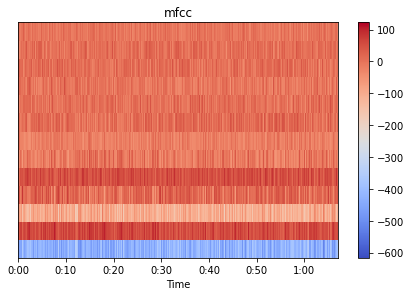

In [ ]:
mfcc = static_features_df['feature'][15]

import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc')
plt.show

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# split the dataset into independent and dependent sections (static first)
X_static = np.array(static_features_df['feature'].tolist())
y_static = np.array(static_features_df['class'].tolist())

# normalize data
trainmax = np.max(X_static)
trainmin = np.min(X_static)
trainrange= trainmax - trainmin
X_static = (((X_static - trainmin)/trainrange) - 0.5)*2

# encode labels
label_encoder = LabelEncoder()
y_static = to_categorical(label_encoder.fit_transform(y_static))

# split the dataset into a training dataset and a testing dataset
X_static_train1, X_static_test1, ground_static_train1, ground_static_test1 = train_test_split(
    X_static, X_static, test_size=0.2, random_state=0)

print(np.max(X_static_train1), np.min(X_static_train1))
print(np.max(X_static_test1), np.min(X_static_test1))


1.0 -1.0
0.94780827 -0.8905828


In [ ]:
# shape of training set
print(X_static_train1[0].shape)
print('Training set(static features from audio) shape: {shape}'.format(shape=X_static_train1.shape))
print('Testing set(static features from audio) shape: {shape}'.format(shape=X_static_test1.shape))
print(X_static_train1.shape[1])

(13, 2886)
Training set(static features from audio) shape: (211, 13, 2886)
Testing set(static features from audio) shape: (53, 13, 2886)
13


In [ ]:
timesteps = X_static_train1.shape[1]   #13
input_dim = X_static_train1.shape[2] #2886
latent_dim = 2

# create an lstm autoencoder instance
autoencoder = create_LSTM_autoencoder(timesteps, input_dim, latent_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dropout (Dropout)           (None, 13, 2886)          0         
                                                                 
 lstm (LSTM)                 (None, 2)                 23112     
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 repeat_vector (RepeatVector  (None, 13, 2)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 13, 2886)          33350616  
                                                             

In [ ]:
import os
import tensorflow.keras

# ae is trained with new callback
autoencoder.fit(X_static_train1, ground_static_train1, 
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_static_test1, ground_static_test1))

Epoch 1/100
27/27 [==============================] - 8s 81ms/step - loss: 0.1880 - val_loss: 0.0764
Epoch 2/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1430 - val_loss: 0.0742
Epoch 3/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1404 - val_loss: 0.0715
Epoch 4/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1393 - val_loss: 0.0735
Epoch 5/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1378 - val_loss: 0.0717
Epoch 6/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1378 - val_loss: 0.0669
Epoch 7/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1373 - val_loss: 0.0677
Epoch 8/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1373 - val_loss: 0.0669
Epoch 9/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1371 - val_loss: 0.0676
Epoch 10/100
27/27 [==============================] - 1s 50ms/step - loss: 0.1369 - val_loss: 0.0671

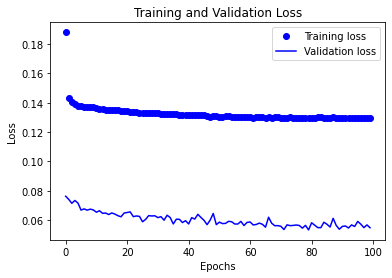

Test loss: 0.0549122579395771


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_static_test1, ground_static_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
# the data is split into training and validation sets once again, 
# including the encoded labels
X_static_train, X_static_test, y_static_train, y_static_test = train_test_split(
    X_static, y_static, test_size=0.2, random_state=0)

# delete??
print(X_static_train.shape,
X_static_test.shape,
y_static_train.shape,
y_static_test.shape)

(211, 13, 2886) (53, 13, 2886) (211, 88) (53, 88)


In [ ]:
classifier = create_LSTM_ae_classifier(timesteps, input_dim, latent_dim, y_static_train.shape[1])
classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dropout_3 (Dropout)         (None, 13, 2886)          0         
                                                                 
 lstm_2 (LSTM)               (None, 2)                 23112     
                                                                 
 dropout_4 (Dropout)         (None, 2)                 0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 13, 2886)          33350616  
                                                           

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([ 0.0215584 ,  0.00357124,  0.02271182,  0.02484661,  0.02070884,
       -0.03163334,  0.04339619,  0.02476608], dtype=float32)

In [ ]:
classifier.get_weights()[0][1]

array([ 0.0215584 ,  0.00357124,  0.02271182,  0.02484661,  0.02070884,
       -0.03163334,  0.04339619,  0.02476608], dtype=float32)

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dropout_3 (Dropout)         (None, 13, 2886)          0         
                                                                 
 lstm_2 (LSTM)               (None, 2)                 23112     
                                                                 
 dropout_4 (Dropout)         (None, 2)                 0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 13, 2886)          33350616  
                                                           

In [ ]:
classifier.fit(X_static_train,
               y_static_train,
               epochs=100,
               batch_size=8,
               shuffle=True,
               validation_data=[X_static_test, y_static_test])

Epoch 1/100
27/27 [==============================] - 7s 87ms/step - loss: 11.6389 - auc: 0.4787 - val_loss: 14.2099 - val_auc: 0.4947
Epoch 2/100
27/27 [==============================] - 1s 52ms/step - loss: 14.4844 - auc: 0.4617 - val_loss: 16.3456 - val_auc: 0.4713
Epoch 3/100
27/27 [==============================] - 1s 52ms/step - loss: 14.9769 - auc: 0.4908 - val_loss: 14.1959 - val_auc: 0.5018
Epoch 4/100
27/27 [==============================] - 1s 52ms/step - loss: 11.6873 - auc: 0.4783 - val_loss: 11.9040 - val_auc: 0.4797
Epoch 5/100
27/27 [==============================] - 1s 52ms/step - loss: 10.6143 - auc: 0.4810 - val_loss: 9.6558 - val_auc: 0.4554
Epoch 6/100
27/27 [==============================] - 1s 52ms/step - loss: 9.1076 - auc: 0.4712 - val_loss: 11.6186 - val_auc: 0.4829
Epoch 7/100
27/27 [==============================] - 1s 52ms/step - loss: 9.1967 - auc: 0.4832 - val_loss: 12.2280 - val_auc: 0.4710
Epoch 8/100
27/27 [==============================] - 1s 52ms/step

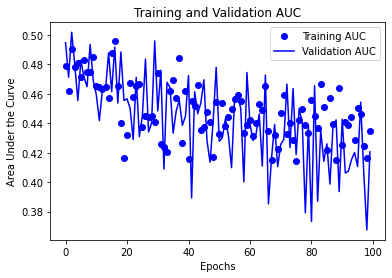

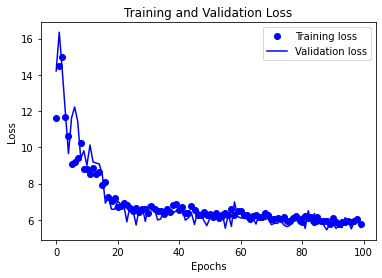

Test loss: 5.582972049713135


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_static_test, y_static_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
metrics_df = pd.DataFrame(columns = ["dataset", "model_name", "features_type", "AUC Value", "Autoencoder Loss"])

auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["xccoverbl"],
                           "model_name": ["LSTM Autoencoder Classifier"], 
                           "features_type": ["static"],  
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.4206245541572571


### Classification Using Dynamic Features (*xccoverbl*) [LSTM AE]

In [ ]:
dynamic_features_df = pd.DataFrame(dynamic_features, columns=['feature', 'class'])
dynamic_features_df.head()

,feature,class
0,"[[34.515472, 34.515472, 34.515472, 34.515472, ...",Acanthis flammea
1,"[[27.098825, 27.098825, 27.098825, 27.098825, ...",Acanthis flammea
2,"[[24.706903, 24.706903, 24.706903, 24.706903, ...",Acanthis flammea
3,"[[15.817281, 15.817281, 15.817281, 15.817281, ...",Acrocephalus palustris
4,"[[63.20504, 63.20504, 63.20504, 63.20504, 63.2...",Acrocephalus palustris


<function matplotlib.pyplot.show(*args, **kw)>

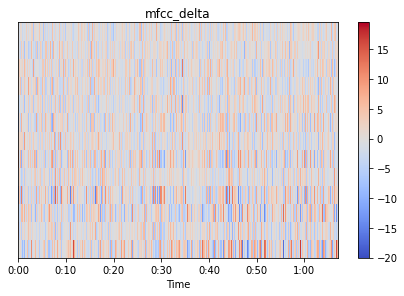

In [ ]:
mfcc_delta = dynamic_features_df['feature'][15]

librosa.display.specshow(mfcc_delta, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc_delta')
plt.show

In [ ]:
# split the dataset into independent and dependent sections (dynamic second)
X_dynamic = np.array(dynamic_features_df['feature'].tolist())
y_dynamic = np.array(dynamic_features_df['class'].tolist())

# https://in.mathworks.com/matlabcentral/answers/364721-how-to-normalize-3d-array-with-negative-and-positive-values-to-values-between-1-and-1
trainmax = np.max(X_dynamic)
trainmin = np.min(X_dynamic)
trainrange= trainmax - trainmin
X_dynamic = (((X_dynamic - trainmin)/trainrange) - 0.5)*2

# the labels are encoded from categorical to one-hot encoding
label_encoder = LabelEncoder()
y_dynamic = to_categorical(label_encoder.fit_transform(y_dynamic))

# split the dataset into a training dataset and a testing dataset
X_dynamic_train1, X_dynamic_test1, ground_dynamic_train1, ground_dynamic_test1 = train_test_split(
    X_dynamic, X_dynamic, test_size=0.2, random_state=0)


In [ ]:
# create an lstm autoencoder instance
autoencoder = create_LSTM_autoencoder(timesteps, input_dim, latent_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dropout_6 (Dropout)         (None, 13, 2886)          0         
                                                                 
 lstm_4 (LSTM)               (None, 2)                 23112     
                                                                 
 dropout_7 (Dropout)         (None, 2)                 0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 13, 2886)          33350616  
                                                           

In [ ]:
autoencoder.fit(X_dynamic_train1, ground_dynamic_train1,
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_dynamic_test1, ground_dynamic_test1))

Epoch 1/100
27/27 [==============================] - 5s 79ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 2/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0018 - val_loss: 0.0013

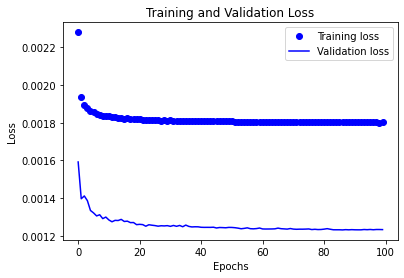

Test loss: 0.0012327504809945822


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_dynamic_test1, ground_dynamic_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
# the data is split into training and validation sets once again, 
# including the encoded labels
X_dynamic_train, X_dynamic_test, y_dynamic_train, y_dynamic_test = train_test_split(
    X_dynamic, y_dynamic, test_size=0.2, random_state=0)

# delete??
print(X_dynamic_train.shape,
X_dynamic_test.shape,
y_dynamic_train.shape,
y_dynamic_test.shape)

(211, 13, 2886) (53, 13, 2886) (211, 88) (53, 88)


In [ ]:
num_classes = y_dynamic_train.shape[1]
classifier = create_LSTM_ae_classifier(timesteps, input_dim, latent_dim, num_classes)
classifier.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dropout_9 (Dropout)         (None, 13, 2886)          0         
                                                                 
 lstm_6 (LSTM)               (None, 2)                 23112     
                                                                 
 dropout_10 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 13, 2886)          33350616  
                                                           

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([-0.0272743 , -0.00377371, -0.04803748,  0.01286799, -0.00796555,
        0.05186309,  0.01670546, -0.00425839], dtype=float32)

In [ ]:
classifier.get_weights()[0][1]

array([-0.0272743 , -0.00377371, -0.04803748,  0.01286799, -0.00796555,
        0.05186309,  0.01670546, -0.00425839], dtype=float32)

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dropout_9 (Dropout)         (None, 13, 2886)          0         
                                                                 
 lstm_6 (LSTM)               (None, 2)                 23112     
                                                                 
 dropout_10 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 13, 2886)          33350616  
                                                           

In [ ]:
# classifier.load_weights(checkpoint_path_1)

classifier.fit(X_dynamic_train,
             y_dynamic_train,
             epochs=100,
             batch_size=8,
             shuffle=True,
             validation_data=[X_dynamic_test, y_dynamic_test])

Epoch 1/100
27/27 [==============================] - 5s 89ms/step - loss: 4.9799 - auc: 0.4503 - val_loss: 4.7927 - val_auc: 0.5285
Epoch 2/100
27/27 [==============================] - 1s 52ms/step - loss: 4.8138 - auc: 0.4723 - val_loss: 4.8964 - val_auc: 0.3926
Epoch 3/100
27/27 [==============================] - 2s 59ms/step - loss: 4.6134 - auc: 0.5179 - val_loss: 4.8024 - val_auc: 0.3485
Epoch 4/100
27/27 [==============================] - 2s 65ms/step - loss: 4.5872 - auc: 0.4787 - val_loss: 4.9095 - val_auc: 0.3420
Epoch 5/100
27/27 [==============================] - 2s 61ms/step - loss: 4.6172 - auc: 0.4950 - val_loss: 4.8944 - val_auc: 0.3042
Epoch 6/100
27/27 [==============================] - 2s 59ms/step - loss: 4.5662 - auc: 0.5145 - val_loss: 4.8862 - val_auc: 0.3017
Epoch 7/100
27/27 [==============================] - 2s 58ms/step - loss: 4.5652 - auc: 0.5035 - val_loss: 4.8309 - val_auc: 0.3465
Epoch 8/100
27/27 [==============================] - 2s 62ms/step - loss: 4.

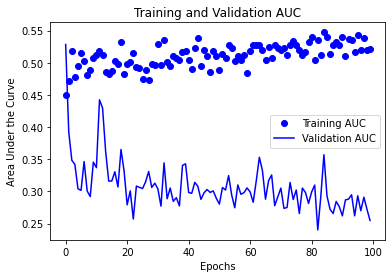

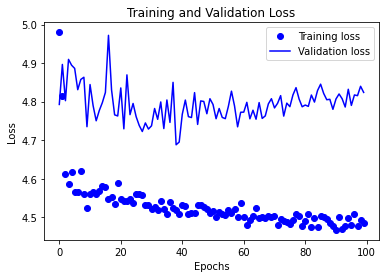

Test loss: 4.823902130126953


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_dynamic_test, y_dynamic_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
# df = pd.DataFrame(columns = ["dataset", "model_name", "features_type", "AUC Value", "MAP value"])
auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["xccoverbl"],
                           "model_name": ["LSTM Autoencoder Classifier"], 
                           "features_type": ["dynamic"], 
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.2548479437828064


## ***Deep Autoencoder***

### Classification Using Static Features (*xccoverbl*) [Deep AE]

In [ ]:
# create an lstm autoencoder instance
autoencoder = create_deep_autoencoder(timesteps, input_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dense_2 (Dense)             (None, 13, 100)           288700    
                                                                 
 dense_3 (Dense)             (None, 13, 50)            5050      
                                                                 
 dense_4 (Dense)             (None, 13, 25)            1275      
                                                                 
 dense_5 (Dense)             (None, 13, 50)            1300      
                                                                 
 dense_6 (Dense)             (None, 13, 100)           5100      
                                                                 
 dense_7 (Dense)             (None, 13, 2886)          2914

In [ ]:
autoencoder.fit(X_static_train1, ground_static_train1, 
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_static_test1, ground_static_test1))

Epoch 1/100
27/27 [==============================] - 1s 17ms/step - loss: 0.0330 - val_loss: 0.0207
Epoch 2/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0171 - val_loss: 0.0192
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.0170
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0136 - val_loss: 0.0168
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0135 - val_loss: 0.0167
Epoch 6/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0167
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0135 - val_loss: 0.0167
Epoch 8/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0167
Epoch 9/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0167
Epoch 10/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0167
Epoch 11

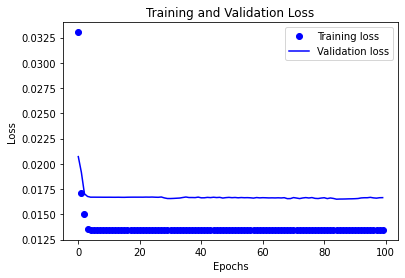

Test loss: 0.016650022938847542


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_static_test1, ground_static_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
classifier = create_deep_ae_classifier(timesteps, input_dim, y_static_train.shape[1])
classifier.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dense_8 (Dense)             (None, 13, 100)           288700    
                                                                 
 dense_9 (Dense)             (None, 13, 50)            5050      
                                                                 
 dense_10 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_11 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_12 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_13 (Dense)            (None, 13, 2886)          2914

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([ 0.0099413 , -0.02142625, -0.01105027, -0.0337973 , -0.05273893,
       -0.04688703, -0.06897017, -0.01659511, -0.02470867, -0.0271489 ,
       -0.00307306, -0.07776134, -0.08372647,  0.03918609, -0.029679  ,
       -0.08013497,  0.01395402, -0.01344038, -0.02736475,  0.01531216,
        0.01525662, -0.03433264, -0.03347706, -0.05432216, -0.02520485,
       -0.04952851,  0.01519899,  0.03443388,  0.03189725,  0.04247582,
        0.0309941 ,  0.03606039, -0.07059357, -0.05523767,  0.02145472,
        0.01161512,  0.04399514, -0.05762541, -0.07968132,  0.012754  ,
       -0.03426949,  0.02082347,  0.00019704, -0.02058135, -0.01040614,
       -0.0772292 ,  0.03406437, -0.07772406, -0.01626362, -0.05747046,
        0.00745386, -0.06823958, -0.00403281,  0.02686954,  0.00773681,
       -0.02569617,  0.01181821,  0.03950263,  0.00872737, -0.08023801,
       -0.0558887 , -0.0321069 , -0.01318122, -0.03614789,  0.02700351,
       -0.01619022,  0.02298514, -0.03420123, -0.00419285, -0.03

In [ ]:
classifier.get_weights()[0][1]

array([ 0.0099413 , -0.02142625, -0.01105027, -0.0337973 , -0.05273893,
       -0.04688703, -0.06897017, -0.01659511, -0.02470867, -0.0271489 ,
       -0.00307306, -0.07776134, -0.08372647,  0.03918609, -0.029679  ,
       -0.08013497,  0.01395402, -0.01344038, -0.02736475,  0.01531216,
        0.01525662, -0.03433264, -0.03347706, -0.05432216, -0.02520485,
       -0.04952851,  0.01519899,  0.03443388,  0.03189725,  0.04247582,
        0.0309941 ,  0.03606039, -0.07059357, -0.05523767,  0.02145472,
        0.01161512,  0.04399514, -0.05762541, -0.07968132,  0.012754  ,
       -0.03426949,  0.02082347,  0.00019704, -0.02058135, -0.01040614,
       -0.0772292 ,  0.03406437, -0.07772406, -0.01626362, -0.05747046,
        0.00745386, -0.06823958, -0.00403281,  0.02686954,  0.00773681,
       -0.02569617,  0.01181821,  0.03950263,  0.00872737, -0.08023801,
       -0.0558887 , -0.0321069 , -0.01318122, -0.03614789,  0.02700351,
       -0.01619022,  0.02298514, -0.03420123, -0.00419285, -0.03

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dense_8 (Dense)             (None, 13, 100)           288700    
                                                                 
 dense_9 (Dense)             (None, 13, 50)            5050      
                                                                 
 dense_10 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_11 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_12 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_13 (Dense)            (None, 13, 2886)          2914

In [ ]:
classifier.fit(X_static_train,
               y_static_train,
               epochs=100,
               batch_size=8,
               shuffle=True,
               validation_data=[X_static_test, y_static_test])

Epoch 1/100
27/27 [==============================] - 2s 24ms/step - loss: 71.7716 - auc: 0.4801 - val_loss: 53.3050 - val_auc: 0.5032
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 50.3340 - auc: 0.4991 - val_loss: 55.8004 - val_auc: 0.4825
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 42.0562 - auc: 0.4860 - val_loss: 15.7442 - val_auc: 0.4698
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 5.0263 - auc: 0.5477 - val_loss: 5.3156 - val_auc: 0.5130
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 4.3997 - auc: 0.5724 - val_loss: 5.4465 - val_auc: 0.4937
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 4.3600 - auc: 0.5737 - val_loss: 5.5985 - val_auc: 0.5059
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 4.3010 - auc: 0.6149 - val_loss: 5.7093 - val_auc: 0.5058
Epoch 8/100
27/27 [==============================] - 0s 9ms/step - loss: 4.

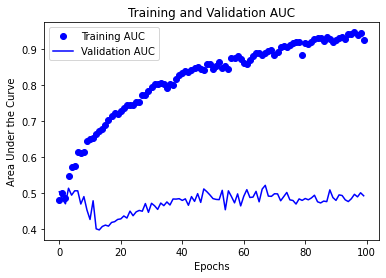

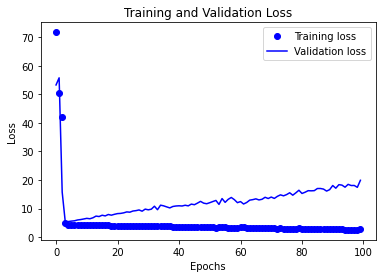

Test loss: 19.89692497253418


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_static_test, y_static_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["xccoverbl"],
                           "model_name": ["Deep Autoencoder Classifier"], 
                           "features_type": ["static"],  
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.4920719265937805


### Classification Using Dynamic Features (*xccoverbl*) [Deep AE]

In [ ]:
# create an lstm autoencoder instance
autoencoder = create_deep_autoencoder(timesteps, input_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dense_15 (Dense)            (None, 13, 100)           288700    
                                                                 
 dense_16 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_17 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_18 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_19 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_20 (Dense)            (None, 13, 2886)          2914

In [ ]:
# autoencoder.load_weights(checkpoint_path)

autoencoder.fit(X_dynamic_train1, ground_dynamic_train1,
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_dynamic_test1, ground_dynamic_test1))

Epoch 1/100
27/27 [==============================] - 1s 17ms/step - loss: 0.1053 - val_loss: 0.0027
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 1

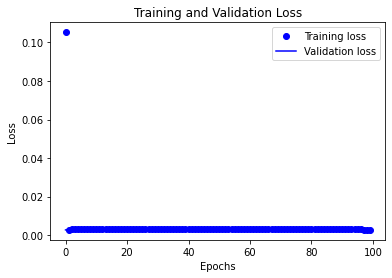

Test loss: 0.002814413281157613


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_dynamic_test1, ground_dynamic_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
num_classes = y_dynamic_train.shape[1]
classifier = create_deep_ae_classifier(timesteps, input_dim, num_classes)
classifier.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dense_21 (Dense)            (None, 13, 100)           288700    
                                                                 
 dense_22 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_23 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_24 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_25 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_26 (Dense)            (None, 13, 2886)          2914

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([-0.04063155, -0.01589112, -0.0040202 , -0.01696406, -0.04258628,
        0.03267506, -0.04530585,  0.02988848, -0.00919953, -0.00156207,
        0.01845333, -0.00899699,  0.03706565, -0.04472322,  0.03276388,
       -0.03935083,  0.02006944,  0.03317454, -0.00853282,  0.04578462,
        0.02169062,  0.01060237,  0.01846141,  0.01370539, -0.00847162,
        0.04875518, -0.02706451,  0.05623313, -0.02867154,  0.02088587,
       -0.0038244 ,  0.02358846,  0.01112631,  0.05125328, -0.02066742,
       -0.01255258,  0.02644689,  0.02414407,  0.01200899, -0.00936926,
       -0.02085461, -0.04025939,  0.01343215, -0.01114575,  0.01062035,
        0.01218845, -0.01287706, -0.00017425, -0.00240638, -0.01423539,
       -0.00363758,  0.06142075, -0.0295927 ,  0.03684394,  0.01072245,
        0.01422544,  0.01301303, -0.00609374, -0.04471369,  0.05420158,
       -0.00979225,  0.05553606,  0.01951482,  0.02113353,  0.04327217,
        0.02117474,  0.06347579,  0.02163042, -0.00791285, -0.00

In [ ]:
classifier.get_weights()[0][1]

array([-0.04063155, -0.01589112, -0.0040202 , -0.01696406, -0.04258628,
        0.03267506, -0.04530585,  0.02988848, -0.00919953, -0.00156207,
        0.01845333, -0.00899699,  0.03706565, -0.04472322,  0.03276388,
       -0.03935083,  0.02006944,  0.03317454, -0.00853282,  0.04578462,
        0.02169062,  0.01060237,  0.01846141,  0.01370539, -0.00847162,
        0.04875518, -0.02706451,  0.05623313, -0.02867154,  0.02088587,
       -0.0038244 ,  0.02358846,  0.01112631,  0.05125328, -0.02066742,
       -0.01255258,  0.02644689,  0.02414407,  0.01200899, -0.00936926,
       -0.02085461, -0.04025939,  0.01343215, -0.01114575,  0.01062035,
        0.01218845, -0.01287706, -0.00017425, -0.00240638, -0.01423539,
       -0.00363758,  0.06142075, -0.0295927 ,  0.03684394,  0.01072245,
        0.01422544,  0.01301303, -0.00609374, -0.04471369,  0.05420158,
       -0.00979225,  0.05553606,  0.01951482,  0.02113353,  0.04327217,
        0.02117474,  0.06347579,  0.02163042, -0.00791285, -0.00

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 13, 2886)]        0         
                                                                 
 dense_21 (Dense)            (None, 13, 100)           288700    
                                                                 
 dense_22 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_23 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_24 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_25 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_26 (Dense)            (None, 13, 2886)          2914

In [ ]:
# classifier.load_weights(checkpoint_path_1)

classifier.fit(X_dynamic_train,
             y_dynamic_train,
             epochs=100,
             batch_size=8,
             shuffle=True,
             validation_data=[X_dynamic_test, y_dynamic_test])

Epoch 1/100
27/27 [==============================] - 2s 24ms/step - loss: 4.4818 - auc: 0.5000 - val_loss: 4.4805 - val_auc: 0.5000
Epoch 2/100
27/27 [==============================] - 0s 8ms/step - loss: 4.4771 - auc: 0.5000 - val_loss: 4.4832 - val_auc: 0.5000
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 4.4764 - auc: 0.5000 - val_loss: 4.4860 - val_auc: 0.5000
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 4.4758 - auc: 0.5000 - val_loss: 4.4886 - val_auc: 0.5000
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 4.4751 - auc: 0.5000 - val_loss: 4.4910 - val_auc: 0.5000
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 4.4745 - auc: 0.5000 - val_loss: 4.4935 - val_auc: 0.5000
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 4.4739 - auc: 0.5000 - val_loss: 4.4960 - val_auc: 0.5000
Epoch 8/100
27/27 [==============================] - 0s 9ms/step - loss: 4.4734 - 

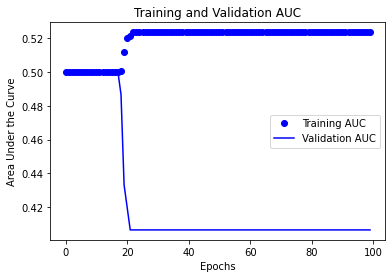

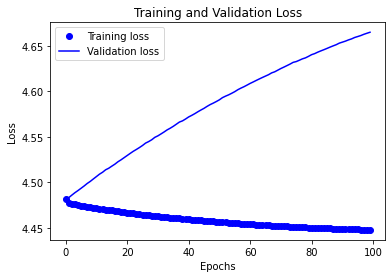

Test loss: 4.665102958679199


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_dynamic_test, y_dynamic_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["xccoverbl"],
                           "model_name": ["Deep Autoencoder Classifier"], 
                           "features_type": ["dynamic"], 
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.4066363275051117


# **KAGGLE BIRD SONG DATASET**

## ***Preprocessing of kaggle_bird_song_dataset***

In [ ]:
# extract features from all the audio
static_features = []
dynamic_features = []
mean_duration = int(get_mean_duration('/content/wavfiles/*'))
print(mean_duration)
for index_num, row in tqdm(df1.iterrows()):
  file_name = df1["file_path"][index_num]
  final_class_labels=row["class"]
  static_data, dynamic_data = extract_features(file_name, mean_duration)
  static_features.append([static_data, final_class_labels])
  dynamic_features.append([dynamic_data, final_class_labels])

3


5422it [15:34,  5.80it/s]


## ***LSTM Autoencoder***

### Classification Using Static Features *(kaggle_bird_song_dataset)* [LSTM AE]

In [ ]:
# convert feature vectors to a pandas data frame
static_features_df = pd.DataFrame(static_features, columns=['feature', 'class'])
static_features_df.head()

,feature,class
0,"[[-350.0325, -354.12903, -354.59747, -336.7447...",Thryomanes bewickii
1,"[[-256.5555, -299.84323, -275.62646, -302.1000...",Thryomanes bewickii
2,"[[-308.9413, -317.01355, -325.21713, -320.3320...",Thryomanes bewickii
3,"[[-275.88477, -324.0183, -321.3188, -318.79575...",Thryomanes bewickii
4,"[[-241.7205, -278.02567, -246.5653, -269.61224...",Thryomanes bewickii


<function matplotlib.pyplot.show(*args, **kw)>

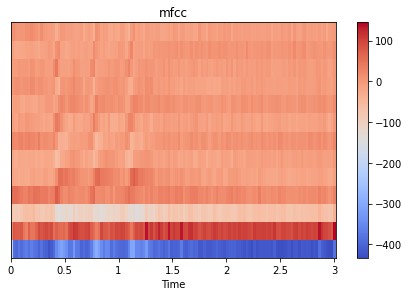

In [ ]:
mfcc = static_features_df['feature'][15]

librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc')
plt.show

In [ ]:
# split the dataset into independent and dependent sections (static first)
X_static = np.array(static_features_df['feature'].tolist())
y_static = np.array(static_features_df['class'].tolist())

trainmax = np.max(X_static)
trainmin = np.min(X_static)
trainrange= trainmax - trainmin
X_static = (((X_static - trainmin)/trainrange) - 0.5)*2

# encode labels
label_encoder = LabelEncoder()
y_static = to_categorical(label_encoder.fit_transform(y_static))

# split the dataset into a training dataset and a testing dataset
X_static_train1, X_static_test1, ground_static_train1, ground_static_test1 = train_test_split(
    X_static, X_static, test_size=0.2, random_state=0)


In [ ]:
# shape of training set
print(X_static_train1[0].shape)
print('Training set(static features from audio) shape: {shape}'.format(shape=X_static_train1.shape))
print('Testing set(static features from audio) shape: {shape}'.format(shape=X_static_test1.shape))
print(X_static_train1.shape[1], X_static_train1.shape[2])

(13, 130)
Training set(static features from audio) shape: (4337, 13, 130)
Testing set(static features from audio) shape: (1085, 13, 130)
13 130


In [ ]:
timesteps = X_static_train1.shape[1]   #12
input_dim = X_static_train1.shape[2] #2886
latent_dim = 2

# create an lstm autoencoder instance
autoencoder = create_LSTM_autoencoder(timesteps, input_dim, latent_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 13, 130)]         0         
                                                                 
 dropout_12 (Dropout)        (None, 13, 130)           0         
                                                                 
 lstm_8 (LSTM)               (None, 2)                 1064      
                                                                 
 dropout_13 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 13, 130)           69160     
                                                           

In [ ]:
autoencoder.fit(X_static_train1, ground_static_train1, 
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_static_test1, ground_static_test1))

Epoch 1/100
543/543 [==============================] - 8s 9ms/step - loss: 0.1383 - val_loss: 0.0561
Epoch 2/100
543/543 [==============================] - 4s 7ms/step - loss: 0.1247 - val_loss: 0.0532
Epoch 3/100
543/543 [==============================] - 4s 7ms/step - loss: 0.1228 - val_loss: 0.0521
Epoch 4/100
543/543 [==============================] - 3s 6ms/step - loss: 0.1220 - val_loss: 0.0511
Epoch 5/100
543/543 [==============================] - 4s 6ms/step - loss: 0.1219 - val_loss: 0.0513
Epoch 6/100
543/543 [==============================] - 4s 6ms/step - loss: 0.1217 - val_loss: 0.0520
Epoch 7/100
543/543 [==============================] - 4s 6ms/step - loss: 0.1215 - val_loss: 0.0507
Epoch 8/100
543/543 [==============================] - 4s 7ms/step - loss: 0.1215 - val_loss: 0.0510
Epoch 9/100
543/543 [==============================] - 4s 6ms/step - loss: 0.1212 - val_loss: 0.0499
Epoch 10/100
543/543 [==============================] - 3s 6ms/step - loss: 0.1213 - val_lo

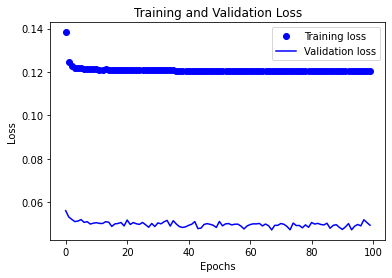

Test loss: 0.04941223934292793


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_static_test1, ground_static_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
# the data is split into training and validation sets once again, 
# including the encoded labels
X_static_train, X_static_test, y_static_train, y_static_test = train_test_split(
    X_static, y_static, test_size=0.2, random_state=0)

print(X_static_train.shape,
X_static_test.shape,
y_static_train.shape,
y_static_test.shape)

(4337, 13, 130) (1085, 13, 130) (4337, 5) (1085, 5)


In [ ]:
classifier = create_LSTM_ae_classifier(timesteps, input_dim, latent_dim, y_static_train.shape[1])
classifier.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dropout_15 (Dropout)        (None, 13, 130)           0         
                                                                 
 lstm_10 (LSTM)              (None, 2)                 1064      
                                                                 
 dropout_16 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 13, 130)           69160     
                                                           

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([ 0.02024416, -0.02748515,  0.10439427,  0.18525101,  0.11560684,
        0.01366553, -0.02018907,  0.02047231], dtype=float32)

In [ ]:
classifier.get_weights()[0][1]

array([ 0.02024416, -0.02748515,  0.10439427,  0.18525101,  0.11560684,
        0.01366553, -0.02018907,  0.02047231], dtype=float32)

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dropout_15 (Dropout)        (None, 13, 130)           0         
                                                                 
 lstm_10 (LSTM)              (None, 2)                 1064      
                                                                 
 dropout_16 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 13, 130)           69160     
                                                           

In [ ]:
classifier.fit(X_static_train,
               y_static_train,
               epochs=100,
               batch_size=8,
               shuffle=True,
               validation_data=[X_static_test, y_static_test])

Epoch 1/100
543/543 [==============================] - 8s 9ms/step - loss: 1.7545 - auc: 0.5309 - val_loss: 1.7410 - val_auc: 0.5385
Epoch 2/100
543/543 [==============================] - 4s 8ms/step - loss: 1.7708 - auc: 0.5235 - val_loss: 1.6187 - val_auc: 0.5414
Epoch 3/100
543/543 [==============================] - 4s 8ms/step - loss: 1.7482 - auc: 0.5249 - val_loss: 1.6733 - val_auc: 0.5321
Epoch 4/100
543/543 [==============================] - 4s 8ms/step - loss: 1.6965 - auc: 0.5286 - val_loss: 1.6449 - val_auc: 0.5346
Epoch 5/100
543/543 [==============================] - 4s 8ms/step - loss: 1.6646 - auc: 0.5394 - val_loss: 1.6220 - val_auc: 0.5477
Epoch 6/100
543/543 [==============================] - 4s 8ms/step - loss: 1.6547 - auc: 0.5434 - val_loss: 1.6793 - val_auc: 0.5399
Epoch 7/100
543/543 [==============================] - 4s 8ms/step - loss: 1.6533 - auc: 0.5454 - val_loss: 1.8025 - val_auc: 0.5305
Epoch 8/100
543/543 [==============================] - 4s 8ms/step - 

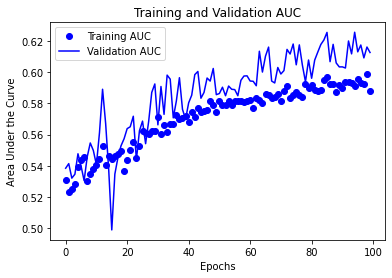

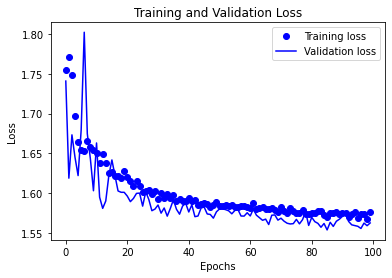

Test loss: 1.5623691082000732


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_static_test, y_static_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["bird song dataset"],
                           "model_name": ["LSTM Autoencoder Classifier"], 
                           "features_type": ["static"], 
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.6125202178955078


### Classification Using Dynamic Features (*kaggle_bird_song_dataset*) [LSTM AE]

In [ ]:
dynamic_features_df = pd.DataFrame(dynamic_features, columns=['feature', 'class'])
dynamic_features_df.head()

,feature,class
0,"[[2.78731, 2.78731, 2.78731, 2.78731, 2.78731,...",Thryomanes bewickii
1,"[[-2.5756352, -2.5756352, -2.5756352, -2.57563...",Thryomanes bewickii
2,"[[-0.55490774, -0.55490774, -0.55490774, -0.55...",Thryomanes bewickii
3,"[[-2.7356038, -2.7356038, -2.7356038, -2.73560...",Thryomanes bewickii
4,"[[1.3294815, 1.3294815, 1.3294815, 1.3294815, ...",Thryomanes bewickii


<function matplotlib.pyplot.show(*args, **kw)>

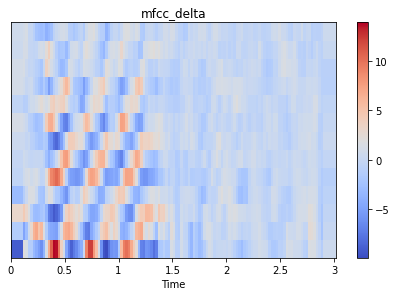

In [ ]:
mfcc_delta = dynamic_features_df['feature'][15]

librosa.display.specshow(mfcc_delta, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc_delta')
plt.show

In [ ]:
# split the dataset into independent and dependent sections (dynamic second)
X_dynamic = np.array(dynamic_features_df['feature'].tolist())
y_dynamic = np.array(dynamic_features_df['class'].tolist())

trainmax = np.max(X_dynamic)
trainmin = np.min(X_dynamic)
trainrange= trainmax - trainmin
X_dynamic = (((X_dynamic - trainmin)/trainrange) - 0.5)*2

# the labels are encoded from categorical to one-hot encoding
label_encoder = LabelEncoder()
y_dynamic = to_categorical(label_encoder.fit_transform(y_dynamic))

# split the dataset into a training dataset and a testing dataset
X_dynamic_train1, X_dynamic_test1, ground_dynamic_train1, ground_dynamic_test1 = train_test_split(
    X_dynamic, X_dynamic, test_size=0.2, random_state=0)


In [ ]:
# create an lstm autoencoder instance
autoencoder = create_LSTM_autoencoder(timesteps, input_dim, latent_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dropout_18 (Dropout)        (None, 13, 130)           0         
                                                                 
 lstm_12 (LSTM)              (None, 2)                 1064      
                                                                 
 dropout_19 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 13, 130)           69160     
                                                          

In [ ]:
# autoencoder.load_weights(checkpoint_path)

autoencoder.fit(X_dynamic_train1, ground_dynamic_train1,
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_dynamic_test1, ground_dynamic_test1))

Epoch 1/100
543/543 [==============================] - 8s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2/100
543/543 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/100
543/543 [==============================] - 4s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/100
543/543 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/100
543/543 [==============================] - 4s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
543/543 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
543/543 [==============================] - 4s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
543/543 [==============================] - 4s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/100
543/543 [==============================] - 4s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/100
543/543 [==============================] - 4s 6ms/step - loss: 0.0012 - val_lo

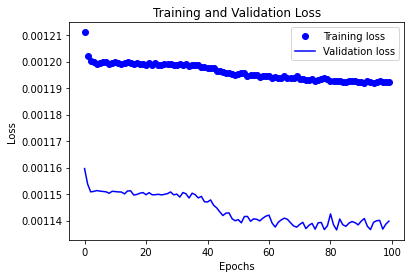

Test loss: 0.0011397876078262925


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_dynamic_test1, ground_dynamic_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
# the data is split into training and validation sets once again, 
# including the encoded labels
X_dynamic_train, X_dynamic_test, y_dynamic_train, y_dynamic_test = train_test_split(
    X_dynamic, y_dynamic, test_size=0.2, random_state=0)

# delete??
print(X_dynamic_train.shape,
X_dynamic_test.shape,
y_dynamic_train.shape,
y_dynamic_test.shape)

(4337, 13, 130) (1085, 13, 130) (4337, 5) (1085, 5)


In [ ]:
classifier = create_LSTM_ae_classifier(timesteps, input_dim, latent_dim, y_dynamic_train.shape[1])
classifier.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dropout_21 (Dropout)        (None, 13, 130)           0         
                                                                 
 lstm_14 (LSTM)              (None, 2)                 1064      
                                                                 
 dropout_22 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_7 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 13, 130)           69160     
                                                          

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([ 0.3703974 , -0.38877895, -0.95921904,  0.3577645 , -0.17053472,
        0.3642784 , -0.4871776 ,  0.19106305], dtype=float32)

In [ ]:
classifier.get_weights()[0][1]

array([ 0.3703974 , -0.38877895, -0.95921904,  0.3577645 , -0.17053472,
        0.3642784 , -0.4871776 ,  0.19106305], dtype=float32)

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dropout_21 (Dropout)        (None, 13, 130)           0         
                                                                 
 lstm_14 (LSTM)              (None, 2)                 1064      
                                                                 
 dropout_22 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_7 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 13, 130)           69160     
                                                          

In [ ]:
classifier.fit(X_dynamic_train,
          y_dynamic_train,
          epochs=100,
          batch_size=8,
          shuffle=True,
          validation_data=[X_dynamic_test, y_dynamic_test])

Epoch 1/100
543/543 [==============================] - 10s 12ms/step - loss: 1.6043 - auc: 0.5378 - val_loss: 1.6055 - val_auc: 0.5353
Epoch 2/100
543/543 [==============================] - 4s 8ms/step - loss: 1.6012 - auc: 0.5458 - val_loss: 1.6004 - val_auc: 0.5482
Epoch 3/100
543/543 [==============================] - 4s 8ms/step - loss: 1.5968 - auc: 0.5548 - val_loss: 1.5935 - val_auc: 0.5608
Epoch 4/100
543/543 [==============================] - 4s 8ms/step - loss: 1.5944 - auc: 0.5555 - val_loss: 1.5903 - val_auc: 0.5628
Epoch 5/100
543/543 [==============================] - 4s 7ms/step - loss: 1.5911 - auc: 0.5629 - val_loss: 1.5923 - val_auc: 0.5564
Epoch 6/100
543/543 [==============================] - 4s 8ms/step - loss: 1.5896 - auc: 0.5617 - val_loss: 1.5878 - val_auc: 0.5652
Epoch 7/100
543/543 [==============================] - 4s 8ms/step - loss: 1.5900 - auc: 0.5596 - val_loss: 1.5837 - val_auc: 0.5688
Epoch 8/100
543/543 [==============================] - 4s 7ms/step 

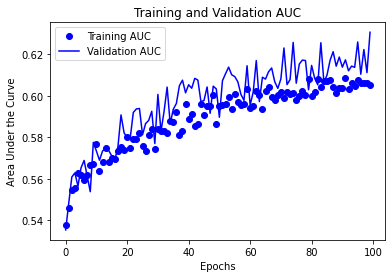

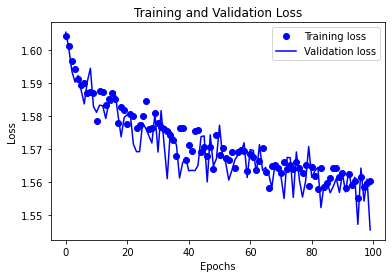

Test loss: 1.5453720092773438


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_dynamic_test, y_dynamic_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["bird song dataset"],
                           "model_name": ["LSTM Autoencoder Classifier"], 
                           "features_type": ["dynamic"], 
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.6305633187294006


## ***Deep Autoencoder***

### Classification Using Static Features (*bird song dataset*) [Deep AE]

In [ ]:
# create an lstm autoencoder instance
autoencoder = create_deep_autoencoder(timesteps, input_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dense_30 (Dense)            (None, 13, 100)           13100     
                                                                 
 dense_31 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_32 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_33 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_34 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_35 (Dense)            (None, 13, 130)           131

In [ ]:
# ae is trained with new callback
autoencoder.fit(X_static_train1, ground_static_train1, 
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_static_test1, ground_static_test1))

Epoch 1/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 2/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 3/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 5/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/100
543/543 [==============================] - 3s 6ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/100
543/543 [==============================] - 4s 7ms/step - loss: 0.0018 - val_lo

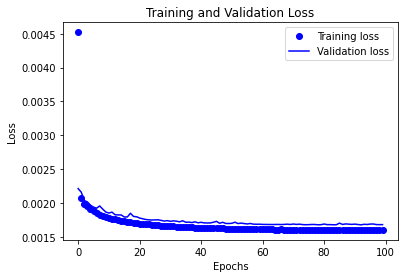

Test loss: 0.0016803492326289415


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_static_test1, ground_static_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
num_classes = y_static_train.shape[1]
classifier = create_deep_ae_classifier(timesteps, input_dim, num_classes)
classifier.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dense_36 (Dense)            (None, 13, 100)           13100     
                                                                 
 dense_37 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_38 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_39 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_40 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_41 (Dense)            (None, 13, 130)           131

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([-0.13858186,  0.31142163, -0.22019123, -0.4919021 ,  0.02258505,
       -0.06545435,  0.08705848,  0.0268706 ,  0.05025915, -0.01746154,
       -0.08723659, -0.05383761, -0.02711874, -0.19562311,  0.11077426,
        0.0617261 ,  0.04528979,  0.0552751 , -0.00982429, -0.06943045,
       -0.16768026, -0.17029418,  0.06043808, -0.09930202,  0.08357382,
       -0.21484615,  0.07430601,  0.13797468,  0.04696621, -0.07903209,
        0.28771642, -0.10611236, -0.05051641,  0.15720163,  0.0614407 ,
        0.34729674, -0.06611527,  0.05188663, -0.03231987,  0.35691032,
       -0.20775203,  0.1479809 , -0.06614511, -0.24425845, -0.01321483,
       -0.12421723, -0.1372254 , -0.02181371,  0.13972417, -0.12172764,
        0.3146965 , -0.02421315,  0.11852185,  0.01495729,  0.19661036,
        0.1796515 , -0.36096993, -0.07705589, -0.38601238,  0.15116066,
       -0.0164418 , -0.3905983 , -0.05807715,  0.10879906,  0.20523106,
       -0.07472546,  0.01975568, -0.56317204, -0.04524017, -0.04

In [ ]:
classifier.get_weights()[0][1]

array([-0.13858186,  0.31142163, -0.22019123, -0.4919021 ,  0.02258505,
       -0.06545435,  0.08705848,  0.0268706 ,  0.05025915, -0.01746154,
       -0.08723659, -0.05383761, -0.02711874, -0.19562311,  0.11077426,
        0.0617261 ,  0.04528979,  0.0552751 , -0.00982429, -0.06943045,
       -0.16768026, -0.17029418,  0.06043808, -0.09930202,  0.08357382,
       -0.21484615,  0.07430601,  0.13797468,  0.04696621, -0.07903209,
        0.28771642, -0.10611236, -0.05051641,  0.15720163,  0.0614407 ,
        0.34729674, -0.06611527,  0.05188663, -0.03231987,  0.35691032,
       -0.20775203,  0.1479809 , -0.06614511, -0.24425845, -0.01321483,
       -0.12421723, -0.1372254 , -0.02181371,  0.13972417, -0.12172764,
        0.3146965 , -0.02421315,  0.11852185,  0.01495729,  0.19661036,
        0.1796515 , -0.36096993, -0.07705589, -0.38601238,  0.15116066,
       -0.0164418 , -0.3905983 , -0.05807715,  0.10879906,  0.20523106,
       -0.07472546,  0.01975568, -0.56317204, -0.04524017, -0.04

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dense_36 (Dense)            (None, 13, 100)           13100     
                                                                 
 dense_37 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_38 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_39 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_40 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_41 (Dense)            (None, 13, 130)           131

In [ ]:
classifier.fit(X_static_train,
               y_static_train,
               epochs=100,
               batch_size=8,
               shuffle=True,
               validation_data=[X_static_test, y_static_test])

Epoch 1/100
543/543 [==============================] - 5s 7ms/step - loss: 1.5826 - auc: 0.5862 - val_loss: 1.5302 - val_auc: 0.6549
Epoch 2/100
543/543 [==============================] - 3s 6ms/step - loss: 1.4340 - auc: 0.7076 - val_loss: 1.3332 - val_auc: 0.7569
Epoch 3/100
543/543 [==============================] - 3s 6ms/step - loss: 1.1455 - auc: 0.8291 - val_loss: 0.9726 - val_auc: 0.8787
Epoch 4/100
543/543 [==============================] - 3s 6ms/step - loss: 1.0132 - auc: 0.8669 - val_loss: 0.9954 - val_auc: 0.8724
Epoch 5/100
543/543 [==============================] - 3s 6ms/step - loss: 0.9370 - auc: 0.8867 - val_loss: 0.9000 - val_auc: 0.8963
Epoch 6/100
543/543 [==============================] - 3s 6ms/step - loss: 0.8950 - auc: 0.8965 - val_loss: 0.8729 - val_auc: 0.9037
Epoch 7/100
543/543 [==============================] - 5s 8ms/step - loss: 0.8831 - auc: 0.8991 - val_loss: 0.8949 - val_auc: 0.8977
Epoch 8/100
543/543 [==============================] - 3s 6ms/step - 

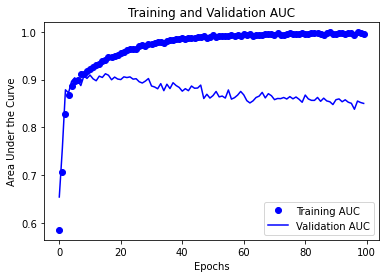

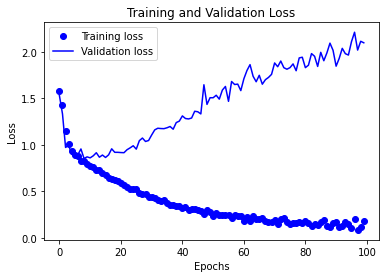

Test loss: 2.0982542037963867


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_static_test, y_static_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["bird song dataset"],
                           "model_name": ["Deep Autoencoder Classifier"], 
                           "features_type": ["static"],  
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.8502876162528992


### Classification Using Dynamic Features (*bird song dataset*) [Deep AE]

In [ ]:
# create an lstm autoencoder instance
autoencoder = create_deep_autoencoder(timesteps, input_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dense_43 (Dense)            (None, 13, 100)           13100     
                                                                 
 dense_44 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_45 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_46 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_47 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_48 (Dense)            (None, 13, 130)           131

In [ ]:
autoencoder.fit(X_dynamic_train1, ground_dynamic_train1,
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_dynamic_test1, ground_dynamic_test1))

Epoch 1/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0138 - val_loss: 0.0014
Epoch 2/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
543/543 [==============================] - 3s 5ms/step - loss: 0.0014 - val_lo

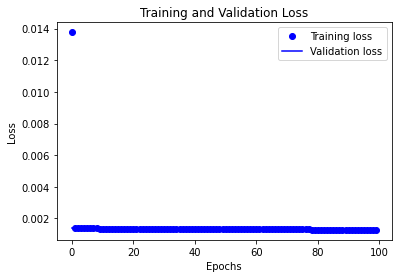

Test loss: 0.001295750611461699


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_dynamic_test1, ground_dynamic_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
num_classes = y_dynamic_train.shape[1]
classifier = create_deep_ae_classifier(timesteps, input_dim, num_classes)
classifier.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dense_49 (Dense)            (None, 13, 100)           13100     
                                                                 
 dense_50 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_51 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_52 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_53 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_54 (Dense)            (None, 13, 130)           131

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([ 0.11623288, -0.12201469, -0.11922246, -0.15709507, -0.15822932,
       -0.04190244, -0.03954777,  0.06685484, -0.00296577,  0.13697506,
       -0.02291496,  0.09192592, -0.0406313 , -0.11419054,  0.0143161 ,
       -0.06003438,  0.12393507,  0.08749196, -0.03889902,  0.05611202,
        0.07436343,  0.21530293,  0.50117624, -0.00336999,  0.13036872,
        0.01576411, -0.11364172, -0.12297939,  0.08090735, -0.18034941,
        0.04325475, -0.00648435,  0.1930909 ,  0.2918175 ,  0.7574449 ,
        0.1440337 , -0.14226685, -0.037265  , -0.06785282, -0.05420421,
        0.15321198,  0.10634201,  0.00653274, -0.13941695, -0.05377239,
        0.09678172, -0.0853925 ,  0.00511772,  0.09633196,  0.09527111,
        0.0494219 ,  0.10200937,  0.21887015,  0.03791023,  0.05986948,
        0.06987733,  0.07671751, -0.08383569,  0.33732563, -0.05962655,
        0.35379514,  0.05420616,  0.12477072, -0.05881969, -0.04550885,
        0.10352129,  0.14377551,  0.08173609,  0.03556705,  0.12

In [ ]:
classifier.get_weights()[0][1]

array([ 0.11623288, -0.12201469, -0.11922246, -0.15709507, -0.15822932,
       -0.04190244, -0.03954777,  0.06685484, -0.00296577,  0.13697506,
       -0.02291496,  0.09192592, -0.0406313 , -0.11419054,  0.0143161 ,
       -0.06003438,  0.12393507,  0.08749196, -0.03889902,  0.05611202,
        0.07436343,  0.21530293,  0.50117624, -0.00336999,  0.13036872,
        0.01576411, -0.11364172, -0.12297939,  0.08090735, -0.18034941,
        0.04325475, -0.00648435,  0.1930909 ,  0.2918175 ,  0.7574449 ,
        0.1440337 , -0.14226685, -0.037265  , -0.06785282, -0.05420421,
        0.15321198,  0.10634201,  0.00653274, -0.13941695, -0.05377239,
        0.09678172, -0.0853925 ,  0.00511772,  0.09633196,  0.09527111,
        0.0494219 ,  0.10200937,  0.21887015,  0.03791023,  0.05986948,
        0.06987733,  0.07671751, -0.08383569,  0.33732563, -0.05962655,
        0.35379514,  0.05420616,  0.12477072, -0.05881969, -0.04550885,
        0.10352129,  0.14377551,  0.08173609,  0.03556705,  0.12

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 13, 130)]         0         
                                                                 
 dense_49 (Dense)            (None, 13, 100)           13100     
                                                                 
 dense_50 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_51 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_52 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_53 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_54 (Dense)            (None, 13, 130)           131

In [ ]:
# classifier.load_weights(checkpoint_path_1)

classifier.fit(X_dynamic_train,
             y_dynamic_train,
             epochs=100,
             batch_size=8,
             shuffle=True,
             validation_data=[X_dynamic_test, y_dynamic_test])

Epoch 1/100
543/543 [==============================] - 4s 6ms/step - loss: 1.4737 - auc: 0.6744 - val_loss: 1.3411 - val_auc: 0.7526
Epoch 2/100
543/543 [==============================] - 3s 6ms/step - loss: 1.2512 - auc: 0.7896 - val_loss: 1.2349 - val_auc: 0.7980
Epoch 3/100
543/543 [==============================] - 3s 6ms/step - loss: 1.0977 - auc: 0.8424 - val_loss: 1.1612 - val_auc: 0.8249
Epoch 4/100
543/543 [==============================] - 3s 6ms/step - loss: 0.9924 - auc: 0.8727 - val_loss: 1.1084 - val_auc: 0.8405
Epoch 5/100
543/543 [==============================] - 3s 6ms/step - loss: 0.8968 - auc: 0.8974 - val_loss: 1.0965 - val_auc: 0.8503
Epoch 6/100
543/543 [==============================] - 3s 6ms/step - loss: 0.8158 - auc: 0.9160 - val_loss: 1.0947 - val_auc: 0.8546
Epoch 7/100
543/543 [==============================] - 3s 6ms/step - loss: 0.7386 - auc: 0.9317 - val_loss: 1.1304 - val_auc: 0.8532
Epoch 8/100
543/543 [==============================] - 3s 6ms/step - 

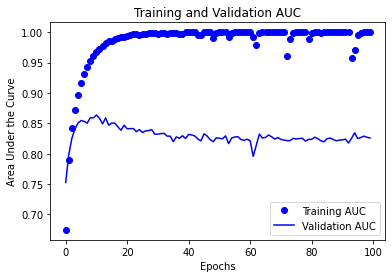

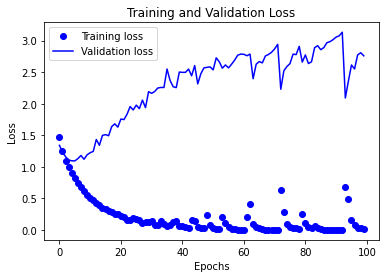

Test loss: 2.7592248916625977


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_dynamic_test, y_dynamic_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
# df = pd.DataFrame(columns = ["dataset", "model_name", "features_type", "AUC Value", "MAP value"])

auc_metric = score[1]
print("AUC: ", auc_metric)

# y_pred = classifier.predict(X_dynamic_test)
# calculate mean average precision metric

df_new_row = pd.DataFrame({"dataset": ["bird song dataset"],
                           "model_name": ["Deep Autoencoder Classifier"], 
                           "features_type": ["dynamic"], 
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.8257889747619629


# **NIPS4B DATASET**

## ***Preprocessing of nips4b dataset***

In [ ]:
# extract features from all the audio
static_features = []
dynamic_features = []
mean_duration = int(get_mean_duration('/content/nips4b/train/*')) 
print(mean_duration)
for index_num, row in tqdm(df2.iterrows()):
  file_name = df2["Filename"][index_num]
  # final_class_labels=row[df2.drop('Filename', axis=1)]
  static_data, dynamic_data = extract_features(file_name, mean_duration)
  static_features.append([static_data])
  dynamic_features.append([dynamic_data])
final_class_labels=df2.iloc[: , -87:]

4


687it [00:07, 96.26it/s]


## ***LSTM Autoencoder***

### Classification Using Static Features *(nips4b)* [LSTM AE]

In [ ]:
static_features_df = pd.DataFrame()

In [ ]:
# convert feature vectors to a pandas data frame
static_features_df["feature"] = pd.DataFrame(static_features)
static_features_df = static_features_df.join(final_class_labels)

print(static_features_df.head())

                                             feature  1  2  3  4  5  6  7  8  \
0  [[-567.60254, -550.12244, -540.171, -544.1713,...  0  0  0  1  0  0  0  0   
1  [[-656.80743, -602.28394, -636.1534, -604.7865...  0  0  0  0  0  0  0  0   
2  [[-609.12024, -606.5491, -614.1389, -592.658, ...  0  0  0  0  0  0  0  0   
3  [[-438.9908, -422.47485, -415.7391, -406.9043,...  0  0  0  0  0  0  0  0   
4  [[-433.1866, -420.077, -428.65744, -421.0965, ...  0  0  0  0  0  0  0  0   

   9  ...  78  79  80  81  82  83  84  85  86  87  
0  0  ...   0   0   0   0   0   0   0   0   0   0  
1  0  ...   1   0   0   0   0   0   0   0   0   0  
2  0  ...   0   0   0   0   0   0   0   0   0   0  
3  0  ...   0   0   0   0   0   0   1   0   0   0  
4  0  ...   0   0   0   0   0   0   1   0   0   0  

[5 rows x 88 columns]


<function matplotlib.pyplot.show(*args, **kw)>

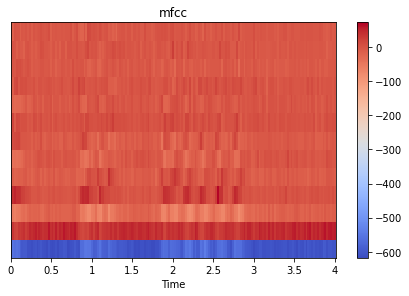

In [ ]:
mfcc = static_features_df['feature'][15]

librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc')
plt.show

In [ ]:
# split the dataset into independent and dependent sections (static first)
X_static = np.array(static_features_df['feature'].tolist())
# y_static = np.array(static_features_df['class'].tolist())

trainmax = np.max(X_static)
trainmin = np.min(X_static)
trainrange= trainmax - trainmin
X_static = (((X_static - trainmin)/trainrange) - 0.5)*2

# encode labels
# label_encoder = LabelEncoder()
y_static = df2.iloc[:, -87:]
# labels are already one-hot encoded

# split the dataset into a training dataset and a testing dataset
X_static_train1, X_static_test1, ground_static_train1, ground_static_test1 = train_test_split(
    X_static, X_static, test_size=0.2, random_state=0)


In [ ]:
# shape of training set
print(X_static_train1[0].shape)
print('Training set(static features from audio) shape: {shape}'.format(shape=X_static_train1.shape))
print('Testing set(static features from audio) shape: {shape}'.format(shape=X_static_test1.shape))
print(X_static_train1.shape[1], X_static_train1.shape[2])

(13, 173)
Training set(static features from audio) shape: (549, 13, 173)
Testing set(static features from audio) shape: (138, 13, 173)
13 173


In [ ]:
timesteps = X_static_train1.shape[1]   #12
input_dim = X_static_train1.shape[2] #2886
latent_dim = 2

# create an lstm autoencoder instance
autoencoder = create_LSTM_autoencoder(timesteps, input_dim, latent_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dropout_24 (Dropout)        (None, 13, 173)           0         
                                                                 
 lstm_16 (LSTM)              (None, 2)                 1408      
                                                                 
 dropout_25 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_8 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_17 (LSTM)              (None, 13, 173)           121792    
                                                          

In [ ]:
autoencoder.fit(X_static_train1, ground_static_train1, 
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_static_test1, ground_static_test1))

Epoch 1/100
69/69 [==============================] - 4s 17ms/step - loss: 0.2754 - val_loss: 0.1066
Epoch 2/100
69/69 [==============================] - 0s 7ms/step - loss: 0.1971 - val_loss: 0.0976
Epoch 3/100
69/69 [==============================] - 0s 7ms/step - loss: 0.1935 - val_loss: 0.0936
Epoch 4/100
69/69 [==============================] - 0s 7ms/step - loss: 0.1914 - val_loss: 0.0909
Epoch 5/100
69/69 [==============================] - 0s 7ms/step - loss: 0.1903 - val_loss: 0.0913
Epoch 6/100
69/69 [==============================] - 0s 7ms/step - loss: 0.1899 - val_loss: 0.0894
Epoch 7/100
69/69 [==============================] - 0s 7ms/step - loss: 0.1891 - val_loss: 0.0881
Epoch 8/100
69/69 [==============================] - 1s 7ms/step - loss: 0.1883 - val_loss: 0.0887
Epoch 9/100
69/69 [==============================] - 0s 7ms/step - loss: 0.1881 - val_loss: 0.0879
Epoch 10/100
69/69 [==============================] - 0s 7ms/step - loss: 0.1879 - val_loss: 0.0865
Epoch 11

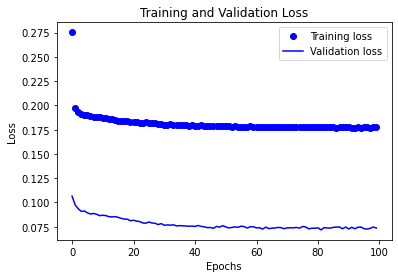

Test loss: 0.07373537868261337


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_static_test1, ground_static_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
# the data is split into training and validation sets once again, 
# including the encoded labels
X_static_train, X_static_test, y_static_train, y_static_test = train_test_split(
    X_static, y_static, test_size=0.2, random_state=0)

# delete??
print(X_static_train.shape,
X_static_test.shape,
y_static_train.shape,
y_static_test.shape)

(549, 13, 173) (138, 13, 173) (549, 87) (138, 87)


In [ ]:
classifier = create_LSTM_ae_classifier(timesteps, input_dim, latent_dim, y_static_train.shape[1])
classifier.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dropout_27 (Dropout)        (None, 13, 173)           0         
                                                                 
 lstm_18 (LSTM)              (None, 2)                 1408      
                                                                 
 dropout_28 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_19 (LSTM)              (None, 13, 173)           121792    
                                                          

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([ 0.06364134, -0.05902809,  0.09269887, -0.0826812 ,  0.06838468,
        0.12827867,  0.13163611,  0.14204888], dtype=float32)

In [ ]:
classifier.get_weights()[0][1]

array([ 0.06364134, -0.05902809,  0.09269887, -0.0826812 ,  0.06838468,
        0.12827867,  0.13163611,  0.14204888], dtype=float32)

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dropout_27 (Dropout)        (None, 13, 173)           0         
                                                                 
 lstm_18 (LSTM)              (None, 2)                 1408      
                                                                 
 dropout_28 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 13, 2)            0         
 or)                                                             
                                                                 
 lstm_19 (LSTM)              (None, 13, 173)           121792    
                                                          

In [ ]:
classifier.fit(X_static_train,
               y_static_train,
               epochs=100,
               batch_size=8,
               shuffle=True,
               validation_data=[X_static_test, y_static_test])

Epoch 1/100
69/69 [==============================] - 4s 20ms/step - loss: 8.6517 - auc: 0.4940 - val_loss: 8.2941 - val_auc: 0.5135
Epoch 2/100
69/69 [==============================] - 1s 9ms/step - loss: 8.7520 - auc: 0.5108 - val_loss: 9.4264 - val_auc: 0.5006
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 11.1646 - auc: 0.5070 - val_loss: 11.9079 - val_auc: 0.5231
Epoch 4/100
69/69 [==============================] - 1s 8ms/step - loss: 12.3867 - auc: 0.4955 - val_loss: 12.4313 - val_auc: 0.4874
Epoch 5/100
69/69 [==============================] - 1s 8ms/step - loss: 12.3063 - auc: 0.5134 - val_loss: 11.2760 - val_auc: 0.5322
Epoch 6/100
69/69 [==============================] - 1s 8ms/step - loss: 12.2579 - auc: 0.5068 - val_loss: 12.2887 - val_auc: 0.5038
Epoch 7/100
69/69 [==============================] - 1s 8ms/step - loss: 12.0598 - auc: 0.5177 - val_loss: 12.4869 - val_auc: 0.5165
Epoch 8/100
69/69 [==============================] - 1s 9ms/step - loss:

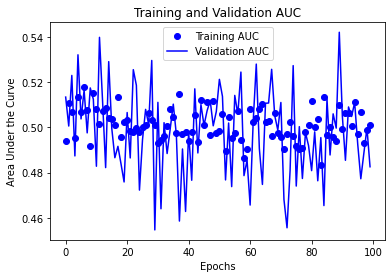

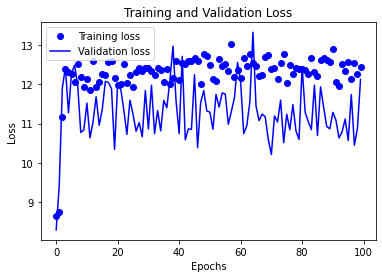

Test loss: 12.1278657913208


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_static_test, y_static_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
# df = pd.DataFrame(columns = ["dataset", "model_name", "features_type", "AUC Value", "MAP value"])

auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["nips4b"],
                           "model_name": ["LSTM Autoencoder Classifier"], 
                           "features_type": ["static"], 
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.48261165618896484


### Classification Using Dynamic Features (*nips4b*) [LSTM AE]

In [ ]:
dynamic_features_df = pd.DataFrame()
dynamic_features_df["feature"] = pd.DataFrame(dynamic_features)
dynamic_features_df = dynamic_features_df.join(final_class_labels)

print(dynamic_features_df.head())

                                             feature  1  2  3  4  5  6  7  8  \
0  [[1.9745504, 1.9745504, 1.9745504, 1.9745504, ...  0  0  0  1  0  0  0  0   
1  [[1.3426208, 1.3426208, 1.3426208, 1.3426208, ...  0  0  0  0  0  0  0  0   
2  [[0.61072487, 0.61072487, 0.61072487, 0.610724...  0  0  0  0  0  0  0  0   
3  [[2.693169, 2.693169, 2.693169, 2.693169, 2.69...  0  0  0  0  0  0  0  0   
4  [[2.0146153, 2.0146153, 2.0146153, 2.0146153, ...  0  0  0  0  0  0  0  0   

   9  ...  78  79  80  81  82  83  84  85  86  87  
0  0  ...   0   0   0   0   0   0   0   0   0   0  
1  0  ...   1   0   0   0   0   0   0   0   0   0  
2  0  ...   0   0   0   0   0   0   0   0   0   0  
3  0  ...   0   0   0   0   0   0   1   0   0   0  
4  0  ...   0   0   0   0   0   0   1   0   0   0  

[5 rows x 88 columns]


<function matplotlib.pyplot.show(*args, **kw)>

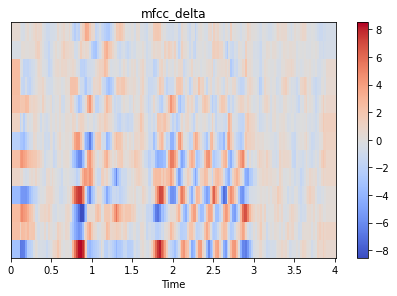

In [ ]:
mfcc_delta = dynamic_features_df['feature'][15]

librosa.display.specshow(mfcc_delta, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc_delta')
plt.show

In [ ]:
# split the dataset into independent and dependent sections (dynamic second)
X_dynamic = np.array(dynamic_features_df['feature'].tolist())
# y_dynamic = np.array(dynamic_features_df['class'].tolist())

trainmax = np.max(X_dynamic)
trainmin = np.min(X_dynamic)
trainrange= trainmax - trainmin
X_dynamic = (((X_dynamic - trainmin)/trainrange) - 0.5)*2

# the labels are encoded from categorical to one-hot encoding
y_dynamic = df2.iloc[:, -87:]

# split the dataset into a training dataset and a testing dataset
X_dynamic_train1, X_dynamic_test1, ground_dynamic_train1, ground_dynamic_test1 = train_test_split(
    X_dynamic, X_dynamic, test_size=0.2, random_state=0)


In [ ]:
# create an lstm autoencoder instance
autoencoder = create_LSTM_autoencoder(timesteps, input_dim, latent_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dropout_30 (Dropout)        (None, 13, 173)           0         
                                                                 
 lstm_20 (LSTM)              (None, 2)                 1408      
                                                                 
 dropout_31 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_10 (RepeatVec  (None, 13, 2)            0         
 tor)                                                            
                                                                 
 lstm_21 (LSTM)              (None, 13, 173)           121792    
                                                          

In [ ]:
autoencoder.fit(X_dynamic_train1, ground_dynamic_train1,
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_dynamic_test1, ground_dynamic_test1))

Epoch 1/100
69/69 [==============================] - 4s 17ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 2/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 3/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 5/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 6/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 7/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 8/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 9/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 10/100
69/69 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 11

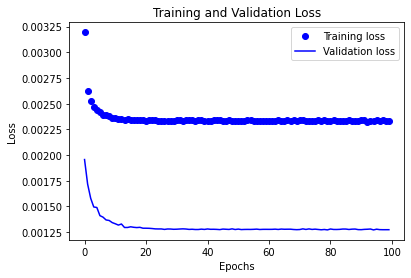

Test loss: 0.001274250214919448


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_dynamic_test1, ground_dynamic_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
X_dynamic_train, X_dynamic_test, y_dynamic_train, y_dynamic_test = train_test_split(
    X_dynamic, y_dynamic, test_size=0.2, random_state=0)

# delete??
print(X_dynamic_train.shape,
X_dynamic_test.shape,
y_dynamic_train.shape,
y_dynamic_test.shape)

(549, 13, 173) (138, 13, 173) (549, 87) (138, 87)


In [ ]:
classifier = create_LSTM_ae_classifier(timesteps, input_dim, latent_dim, y_dynamic_train.shape[1])
classifier.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dropout_33 (Dropout)        (None, 13, 173)           0         
                                                                 
 lstm_22 (LSTM)              (None, 2)                 1408      
                                                                 
 dropout_34 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_11 (RepeatVec  (None, 13, 2)            0         
 tor)                                                            
                                                                 
 lstm_23 (LSTM)              (None, 13, 173)           121792    
                                                          

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([0.23835489, 0.01237525, 0.15871422, 0.18100381, 0.02608421,
       0.13032745, 0.15505582, 0.06240364], dtype=float32)

In [ ]:
classifier.get_weights()[0][1]

array([0.23835489, 0.01237525, 0.15871422, 0.18100381, 0.02608421,
       0.13032745, 0.15505582, 0.06240364], dtype=float32)

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dropout_33 (Dropout)        (None, 13, 173)           0         
                                                                 
 lstm_22 (LSTM)              (None, 2)                 1408      
                                                                 
 dropout_34 (Dropout)        (None, 2)                 0         
                                                                 
 repeat_vector_11 (RepeatVec  (None, 13, 2)            0         
 tor)                                                            
                                                                 
 lstm_23 (LSTM)              (None, 13, 173)           121792    
                                                          

In [ ]:
classifier.fit(X_dynamic_train,
          y_dynamic_train,
          epochs=100,
          batch_size=8,
          shuffle=True,
          validation_data=[X_dynamic_test, y_dynamic_test])

Epoch 1/100
69/69 [==============================] - 4s 22ms/step - loss: 7.7867 - auc: 0.5076 - val_loss: 9.2924 - val_auc: 0.4937
Epoch 2/100
69/69 [==============================] - 1s 8ms/step - loss: 10.0885 - auc: 0.5091 - val_loss: 10.5094 - val_auc: 0.4992
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 12.4579 - auc: 0.5028 - val_loss: 13.4723 - val_auc: 0.5004
Epoch 4/100
69/69 [==============================] - 1s 8ms/step - loss: 13.6613 - auc: 0.4970 - val_loss: 11.8010 - val_auc: 0.4896
Epoch 5/100
69/69 [==============================] - 1s 8ms/step - loss: 13.9120 - auc: 0.4950 - val_loss: 13.4737 - val_auc: 0.5179
Epoch 6/100
69/69 [==============================] - 1s 8ms/step - loss: 13.5456 - auc: 0.4984 - val_loss: 11.0728 - val_auc: 0.5317
Epoch 7/100
69/69 [==============================] - 1s 8ms/step - loss: 13.2768 - auc: 0.4885 - val_loss: 13.4892 - val_auc: 0.4931
Epoch 8/100
69/69 [==============================] - 1s 9ms/step - los

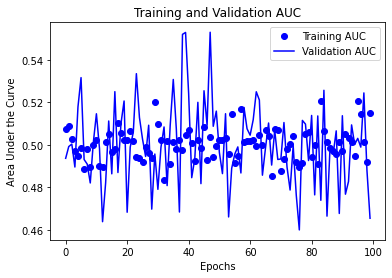

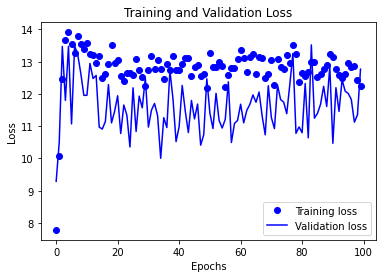

Test loss: 12.768254280090332


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_dynamic_test, y_dynamic_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
# df = pd.DataFrame(columns = ["dataset", "model_name", "features_type", "AUC Value", "MAP value"])

auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["nips4b"],
                           "model_name": ["LSTM Autoencoder Classifier"], 
                           "features_type": ["dynamic"], 
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.46547165513038635


## ***Deep Autoencoder***

### Classification Using Static Features (*nips4b*) [Deep AE]

In [ ]:
# create an lstm autoencoder instance
autoencoder = create_deep_autoencoder(timesteps, input_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dense_58 (Dense)            (None, 13, 100)           17400     
                                                                 
 dense_59 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_60 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_61 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_62 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_63 (Dense)            (None, 13, 173)           174

In [ ]:
# import os
# import tensorflow.keras

# ae is trained with new callback
autoencoder.fit(X_static_train1, ground_static_train1, 
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_static_test1, ground_static_test1))

Epoch 1/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0384 - val_loss: 0.0136
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0135
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0134
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0133
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.0132
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.0132
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.0132
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.0131
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.0132
Epoch 10/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.0131
Epoch 11/

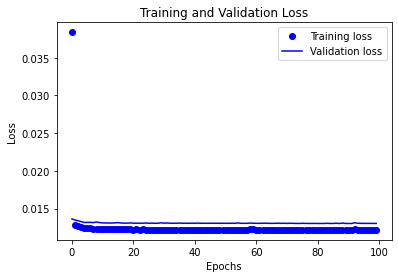

Test loss: 0.013030190020799637


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_static_test1, ground_static_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
num_classes = y_static_train.shape[1]
classifier = create_deep_ae_classifier(timesteps, input_dim, num_classes)
classifier.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dense_64 (Dense)            (None, 13, 100)           17400     
                                                                 
 dense_65 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_66 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_67 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_68 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_69 (Dense)            (None, 13, 173)           174

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([-0.02675298,  0.00916045,  0.04108443,  0.13322762,  0.0842391 ,
        0.05422733, -0.14667405,  0.0641275 , -0.11784107, -0.09896671,
       -0.15382642,  0.07941066, -0.04818227, -0.06361796, -0.08155628,
       -0.09786633,  0.07998792, -0.06843192, -0.08427046,  0.09728496,
        0.05476664,  0.08115073, -0.07526172,  0.07344264, -0.04043286,
       -0.06415461, -0.05022971, -0.0615104 ,  0.06923462, -0.07649206,
       -0.11737654, -0.03262985,  0.03327761,  0.09577303,  0.0443658 ,
        0.07061421, -0.03552536, -0.00062783, -0.07748041,  0.09664355,
       -0.1159546 , -0.01740077, -0.14147301,  0.12335912,  0.06625374,
        0.12952732, -0.10255339, -0.08576023, -0.17432857,  0.14277627,
        0.00637081,  0.09550832, -0.05342841, -0.08380467,  0.11769668,
        0.0285009 ,  0.07821368, -0.01951217,  0.05393949, -0.12904824,
        0.13192366,  0.01966384,  0.07573538, -0.1065983 , -0.13327143,
       -0.18681301, -0.1788812 ,  0.14095408,  0.03054283, -0.16

In [ ]:
classifier.get_weights()[0][1]

array([-0.02675298,  0.00916045,  0.04108443,  0.13322762,  0.0842391 ,
        0.05422733, -0.14667405,  0.0641275 , -0.11784107, -0.09896671,
       -0.15382642,  0.07941066, -0.04818227, -0.06361796, -0.08155628,
       -0.09786633,  0.07998792, -0.06843192, -0.08427046,  0.09728496,
        0.05476664,  0.08115073, -0.07526172,  0.07344264, -0.04043286,
       -0.06415461, -0.05022971, -0.0615104 ,  0.06923462, -0.07649206,
       -0.11737654, -0.03262985,  0.03327761,  0.09577303,  0.0443658 ,
        0.07061421, -0.03552536, -0.00062783, -0.07748041,  0.09664355,
       -0.1159546 , -0.01740077, -0.14147301,  0.12335912,  0.06625374,
        0.12952732, -0.10255339, -0.08576023, -0.17432857,  0.14277627,
        0.00637081,  0.09550832, -0.05342841, -0.08380467,  0.11769668,
        0.0285009 ,  0.07821368, -0.01951217,  0.05393949, -0.12904824,
        0.13192366,  0.01966384,  0.07573538, -0.1065983 , -0.13327143,
       -0.18681301, -0.1788812 ,  0.14095408,  0.03054283, -0.16

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dense_64 (Dense)            (None, 13, 100)           17400     
                                                                 
 dense_65 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_66 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_67 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_68 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_69 (Dense)            (None, 13, 173)           174

In [ ]:
classifier.fit(X_static_train,
               y_static_train,
               epochs=100,
               batch_size=8,
               shuffle=True,
               validation_data=[X_static_test, y_static_test])

Epoch 1/100
69/69 [==============================] - 2s 12ms/step - loss: 7.8390 - auc: 0.4977 - val_loss: 7.6293 - val_auc: 0.5000
Epoch 2/100
69/69 [==============================] - 0s 6ms/step - loss: 7.6171 - auc: 0.5211 - val_loss: 8.0341 - val_auc: 0.5086
Epoch 3/100
69/69 [==============================] - 0s 6ms/step - loss: 13.0533 - auc: 0.5301 - val_loss: 17.5187 - val_auc: 0.5070
Epoch 4/100
69/69 [==============================] - 0s 6ms/step - loss: 16.3582 - auc: 0.4993 - val_loss: 14.3195 - val_auc: 0.5264
Epoch 5/100
69/69 [==============================] - 0s 6ms/step - loss: 14.2627 - auc: 0.5135 - val_loss: 13.4711 - val_auc: 0.5042
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 13.2875 - auc: 0.5138 - val_loss: 13.9383 - val_auc: 0.5018
Epoch 7/100
69/69 [==============================] - 0s 6ms/step - loss: 13.1343 - auc: 0.5025 - val_loss: 13.3979 - val_auc: 0.4695
Epoch 8/100
69/69 [==============================] - 0s 6ms/step - loss:

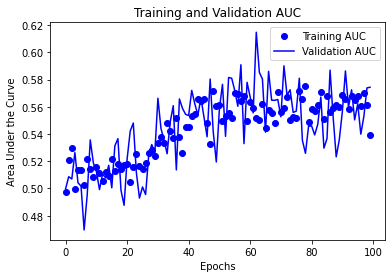

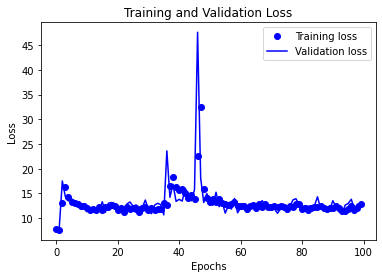

Test loss: 12.07520580291748


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_static_test, y_static_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
# metrics_df = pd.DataFrame(columns = ["dataset", "model_name", "features_type", "AUC Value", "MAP value"])

auc_metric = score[1]
print("AUC: ", auc_metric)

df_new_row = pd.DataFrame({"dataset": ["nips4b"],
                           "model_name": ["Deep Autoencoder Classifier"], 
                           "features_type": ["static"],  
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.5750057101249695


### Classification Using Dynamic Features (*nips4b*) [Deep AE]

In [ ]:
# create an lstm autoencoder instance
autoencoder = create_deep_autoencoder(timesteps, input_dim)

# display the architecture of the model
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dense_71 (Dense)            (None, 13, 100)           17400     
                                                                 
 dense_72 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_73 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_74 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_75 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_76 (Dense)            (None, 13, 173)           174

In [ ]:
autoencoder.fit(X_dynamic_train1, ground_dynamic_train1,
                epochs=100, 
                batch_size=8,
                shuffle=True,
                validation_data=(X_dynamic_test1, ground_dynamic_test1))

Epoch 1/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0971 - val_loss: 0.0051
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 10/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 11/

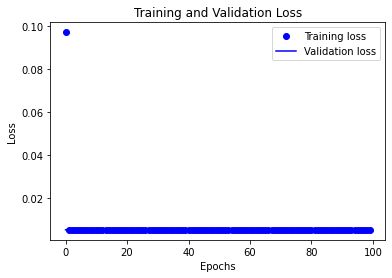

Test loss: 0.005136767867952585


In [ ]:
fig = plot_loss_graph(autoencoder)
plt.show()

ae_loss = autoencoder.evaluate(X_dynamic_test1, ground_dynamic_test1, verbose=0)
print('Test loss:', ae_loss)

In [ ]:
num_classes = y_dynamic_train.shape[1]
classifier = create_deep_ae_classifier(timesteps, input_dim, num_classes)
classifier.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dense_77 (Dense)            (None, 13, 100)           17400     
                                                                 
 dense_78 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_79 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_80 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_81 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_82 (Dense)            (None, 13, 173)           174

In [ ]:
for l1, l2 in zip(classifier.layers[:7], autoencoder.layers[0:7]):
  l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([ 0.04930986, -0.04202601, -0.09467107, -0.13494155, -0.09704729,
        0.09525508, -0.10065699, -0.15029472, -0.03303877, -0.09573618,
       -0.0320005 , -0.12603207, -0.08732727,  0.01853818,  0.08658515,
        0.05253479, -0.05685617, -0.17962803, -0.01083183, -0.09163599,
       -0.10349727, -0.14344499,  0.09294045, -0.01626848, -0.12555718,
        0.13060486,  0.01790249,  0.12271754,  0.08161817,  0.13756396,
       -0.08042863, -0.06172537,  0.01823481,  0.08882653, -0.14368695,
        0.03106399,  0.08494218,  0.02277193,  0.05688297,  0.00979974,
        0.00795261,  0.03489814, -0.17205885,  0.00888778,  0.03458002,
       -0.1068529 , -0.05535601,  0.0013439 ,  0.01036198, -0.05955008,
       -0.08987135, -0.06818588, -0.03270369,  0.0164559 ,  0.07768328,
        0.00751272, -0.09168918,  0.08809866, -0.13420518, -0.07079419,
       -0.09831246, -0.10108497, -0.18396252, -0.16485512,  0.11546884,
        0.0520907 , -0.04111462, -0.01823697,  0.05206052,  0.05

In [ ]:
classifier.get_weights()[0][1]

array([ 0.04930986, -0.04202601, -0.09467107, -0.13494155, -0.09704729,
        0.09525508, -0.10065699, -0.15029472, -0.03303877, -0.09573618,
       -0.0320005 , -0.12603207, -0.08732727,  0.01853818,  0.08658515,
        0.05253479, -0.05685617, -0.17962803, -0.01083183, -0.09163599,
       -0.10349727, -0.14344499,  0.09294045, -0.01626848, -0.12555718,
        0.13060486,  0.01790249,  0.12271754,  0.08161817,  0.13756396,
       -0.08042863, -0.06172537,  0.01823481,  0.08882653, -0.14368695,
        0.03106399,  0.08494218,  0.02277193,  0.05688297,  0.00979974,
        0.00795261,  0.03489814, -0.17205885,  0.00888778,  0.03458002,
       -0.1068529 , -0.05535601,  0.0013439 ,  0.01036198, -0.05955008,
       -0.08987135, -0.06818588, -0.03270369,  0.0164559 ,  0.07768328,
        0.00751272, -0.09168918,  0.08809866, -0.13420518, -0.07079419,
       -0.09831246, -0.10108497, -0.18396252, -0.16485512,  0.11546884,
        0.0520907 , -0.04111462, -0.01823697,  0.05206052,  0.05

In [ ]:
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=[AUC(name='auc', multi_label=False)])
classifier.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 13, 173)]         0         
                                                                 
 dense_77 (Dense)            (None, 13, 100)           17400     
                                                                 
 dense_78 (Dense)            (None, 13, 50)            5050      
                                                                 
 dense_79 (Dense)            (None, 13, 25)            1275      
                                                                 
 dense_80 (Dense)            (None, 13, 50)            1300      
                                                                 
 dense_81 (Dense)            (None, 13, 100)           5100      
                                                                 
 dense_82 (Dense)            (None, 13, 173)           174

In [ ]:
# classifier.load_weights(checkpoint_path_1)

classifier.fit(X_dynamic_train,
             y_dynamic_train,
             epochs=100,
             batch_size=8,
             shuffle=True,
             validation_data=[X_dynamic_test, y_dynamic_test])

Epoch 1/100
69/69 [==============================] - 2s 11ms/step - loss: 7.6464 - auc: 0.5000 - val_loss: 7.6374 - val_auc: 0.5000
Epoch 2/100
69/69 [==============================] - 0s 6ms/step - loss: 7.6419 - auc: 0.5000 - val_loss: 7.6378 - val_auc: 0.5000
Epoch 3/100
69/69 [==============================] - 0s 6ms/step - loss: 7.6387 - auc: 0.5000 - val_loss: 7.6383 - val_auc: 0.5000
Epoch 4/100
69/69 [==============================] - 0s 6ms/step - loss: 7.6356 - auc: 0.5000 - val_loss: 7.6383 - val_auc: 0.5000
Epoch 5/100
69/69 [==============================] - 0s 6ms/step - loss: 7.6327 - auc: 0.5000 - val_loss: 7.6390 - val_auc: 0.5000
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 7.6296 - auc: 0.5000 - val_loss: 7.6393 - val_auc: 0.5000
Epoch 7/100
69/69 [==============================] - 0s 6ms/step - loss: 7.6270 - auc: 0.5014 - val_loss: 7.6398 - val_auc: 0.4994
Epoch 8/100
69/69 [==============================] - 0s 6ms/step - loss: 7.6243 - 

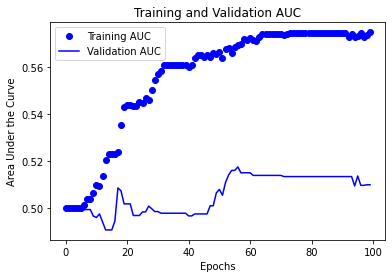

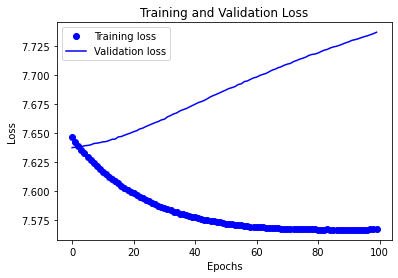

Test loss: 7.7367472648620605


In [ ]:
auc_graph = plot_auc_graph(classifier)
loss_graph = plot_loss_graph(classifier)
plt.show()

score = classifier.evaluate(X_dynamic_test, y_dynamic_test, verbose=0)
print('Test loss:', score[0])

In [ ]:
# df = pd.DataFrame(columns = ["dataset", "model_name", "features_type", "AUC Value", "MAP value"])

auc_metric = score[1]
print("AUC: ", auc_metric)

# y_pred = classifier.predict(X_dynamic_test)
# calculate mean average precision metric

df_new_row = pd.DataFrame({"dataset": ["nips4b"],
                           "model_name": ["Deep Autoencoder Classifier"], 
                           "features_type": ["dynamic"], 
                           "AUC Value": [auc_metric],
                           "Autoencoder Loss": [ae_loss]})
metrics_df = pd.concat([metrics_df, df_new_row], ignore_index=True)

AUC:  0.5099362134933472


# EVALUATION

In [ ]:
display(metrics_df)

,dataset,model_name,features_type,AUC Value,Autoencoder Loss
0,xccoverbl,LSTM Autoencoder Classifier,static,0.420625,0.054912
1,xccoverbl,LSTM Autoencoder Classifier,dynamic,0.254848,0.001233
2,xccoverbl,Deep Autoencoder Classifier,static,0.492072,0.016650
3,xccoverbl,Deep Autoencoder Classifier,dynamic,0.406636,0.002814
4,bird song dataset,LSTM Autoencoder Classifier,static,0.612520,0.049412
5,bird song dataset,LSTM Autoencoder Classifier,dynamic,0.630563,0.001140
6,bird song dataset,Deep Autoencoder Classifier,static,0.850288,0.001680
7,bird song dataset,Deep Autoencoder Classifier,dynamic,0.825789,0.001296
8,nips4b,LSTM Autoencoder Classifier,static,0.482612,0.073735
9,nips4b,LSTM Autoencoder Classifier,dynamic,0.465472,0.001274


In [ ]:
static_metrics_df = metrics_df[metrics_df['features_type'] == "static"]
static_auc_df = static_metrics_df[["dataset", "model_name", "AUC Value"]] # auc values of autoencoder classifier
static_loss_df = static_metrics_df[["dataset", "model_name", "Autoencoder Loss"]]  # reconstruction loss values of ae
display(static_metrics_df)
display(static_auc_df)

,dataset,model_name,features_type,AUC Value,Autoencoder Loss
0,xccoverbl,LSTM Autoencoder Classifier,static,0.420625,0.054912
2,xccoverbl,Deep Autoencoder Classifier,static,0.492072,0.016650
4,bird song dataset,LSTM Autoencoder Classifier,static,0.612520,0.049412
6,bird song dataset,Deep Autoencoder Classifier,static,0.850288,0.001680
8,nips4b,LSTM Autoencoder Classifier,static,0.482612,0.073735
10,nips4b,Deep Autoencoder Classifier,static,0.575006,0.013030


,dataset,model_name,AUC Value
0,xccoverbl,LSTM Autoencoder Classifier,0.420625
2,xccoverbl,Deep Autoencoder Classifier,0.492072
4,bird song dataset,LSTM Autoencoder Classifier,0.612520
6,bird song dataset,Deep Autoencoder Classifier,0.850288
8,nips4b,LSTM Autoencoder Classifier,0.482612
10,nips4b,Deep Autoencoder Classifier,0.575006


In [ ]:
display(static_loss_df)

,dataset,model_name,Autoencoder Loss
0,xccoverbl,LSTM Autoencoder Classifier,0.054912
2,xccoverbl,Deep Autoencoder Classifier,0.016650
4,bird song dataset,LSTM Autoencoder Classifier,0.049412
6,bird song dataset,Deep Autoencoder Classifier,0.001680
8,nips4b,LSTM Autoencoder Classifier,0.073735
10,nips4b,Deep Autoencoder Classifier,0.013030


In [ ]:
dynamic_metrics_df = metrics_df[metrics_df['features_type'] == "dynamic"]
dynamic_auc_df = dynamic_metrics_df[["dataset", "model_name", "AUC Value"]]
dynamic_loss_df = dynamic_metrics_df[["dataset", "model_name", "Autoencoder Loss"]] 
display(dynamic_metrics_df)
display(dynamic_auc_df)

,dataset,model_name,features_type,AUC Value,Autoencoder Loss
1,xccoverbl,LSTM Autoencoder Classifier,dynamic,0.254848,0.001233
3,xccoverbl,Deep Autoencoder Classifier,dynamic,0.406636,0.002814
5,bird song dataset,LSTM Autoencoder Classifier,dynamic,0.630563,0.001140
7,bird song dataset,Deep Autoencoder Classifier,dynamic,0.825789,0.001296
9,nips4b,LSTM Autoencoder Classifier,dynamic,0.465472,0.001274
11,nips4b,Deep Autoencoder Classifier,dynamic,0.509936,0.005137


,dataset,model_name,AUC Value
1,xccoverbl,LSTM Autoencoder Classifier,0.254848
3,xccoverbl,Deep Autoencoder Classifier,0.406636
5,bird song dataset,LSTM Autoencoder Classifier,0.630563
7,bird song dataset,Deep Autoencoder Classifier,0.825789
9,nips4b,LSTM Autoencoder Classifier,0.465472
11,nips4b,Deep Autoencoder Classifier,0.509936


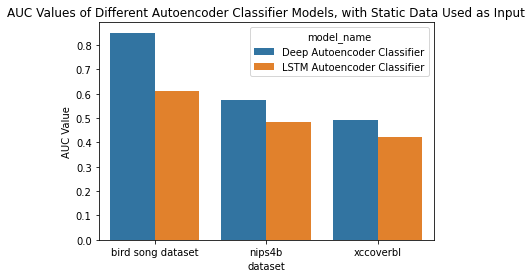

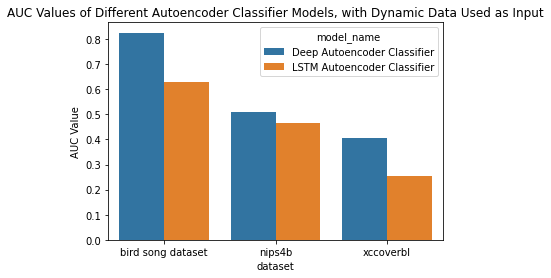

In [ ]:
import seaborn as sns

grouped = static_auc_df.groupby(by=["model_name", "dataset", "AUC Value"], as_index=False).count()
sns.barplot(data=grouped, x="dataset", y="AUC Value", hue="model_name")
plt.title("AUC Values of Different Autoencoder Classifier Models, with Static Data Used as Input")
plt.show()

grouped = dynamic_auc_df.groupby(by=["model_name", "dataset", "AUC Value"], as_index=False).count()
sns.barplot(data=grouped, x="dataset", y="AUC Value", hue="model_name")
plt.title("AUC Values of Different Autoencoder Classifier Models, with Dynamic Data Used as Input")
plt.show()


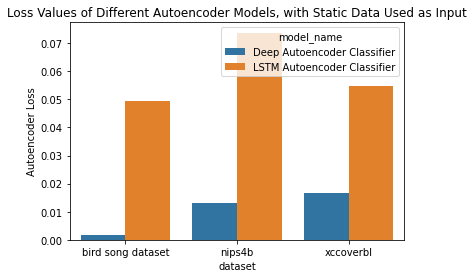

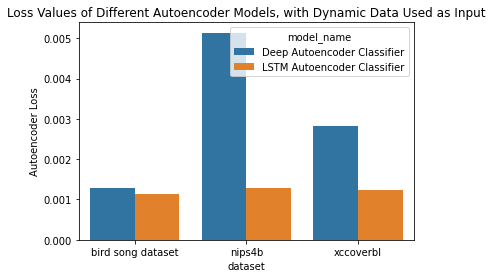

In [ ]:
grouped = static_loss_df.groupby(by=["model_name", "dataset", "Autoencoder Loss"], as_index=False).count()
sns.barplot(data=grouped, x="dataset", y="Autoencoder Loss", hue="model_name")
plt.title("Loss Values of Different Autoencoder Models, with Static Data Used as Input")
plt.show()

grouped = dynamic_loss_df.groupby(by=["model_name", "dataset", "Autoencoder Loss"], as_index=False).count()
sns.barplot(data=grouped, x="dataset", y="Autoencoder Loss", hue="model_name")
plt.title("Loss Values of Different Autoencoder Models, with Dynamic Data Used as Input")
plt.show()
